In [1]:
import numpy  as np
import pandas as pd
import fnmatch
import os
import re

import numpy  as np

from os.path import splitext as ossplitext
import matplotlib.pyplot as plt


In [2]:
def find_files(path_main, pattern, type='separate'):

    list_return = list()
    for dirpath, dirs, files in os.walk(path_main):
        for fname in fnmatch.filter(files, pattern):
            list_return.append((dirpath,fname))

    if type == 'separate':
        list_return = np.asarray(list_return)
        df 			= pd.DataFrame(list_return, columns = ['path','file'])
        df 			= df.sort_values(by=['path'], ascending=True)
        return df.to_numpy()

    if type == 'absolute':
        new_list = list()
        for i,j in list_return:
            new_list.append(os.path.join(i,j))
        new_list = sorted(new_list )
        return np.asarray(new_list)
    else:
        print('error, you need choise type: [separate,absolute]')
        return None

In [3]:
def build_dataframe(files):
    cols = ['queryAbsPath','qId','qIsPesentGT','beta','eta','tau','highSimilarity','qIsIn_eta','type']
    main_df = pd.DataFrame(columns=cols)

    for i in files:
        df = pd.read_csv(i, usecols=cols)
        if df.shape[0]>0:
            main_df = main_df.append(df, ignore_index=True)
    
    return main_df

In [4]:
def build_outcome_dataframe(files):
#     cols = ['imgAbsPath','cosine_similarity']
    cols = ['imgAbsPath_origin','imgAbsPath_current','cosine_similarity']
    main_df = pd.DataFrame(columns=cols)

    for i in files:
        df = pd.read_csv(i, usecols=cols)
        if df.shape[0]>0:
            main_df = main_df.append(df, ignore_index=True)
    return main_df

In [5]:
def create_dir(path):
    try:
        os.makedirs(path, exist_ok=True)
        # print('{} created successfully'.format(path))
        return path
    except:
        print('{} cant be created')
    return None

# PATHs

In [6]:
path_trade       = './results/2_TrADe'

In [7]:
path_save_imgs   = os.path.join(path_trade,'imgs_from_csv')

In [8]:
create_dir(path_save_imgs)

'./results/2_TrADe/imgs_from_csv'

## OPEN outcome dataframe 

In [9]:
all_paths     = list()

max_tracklets = [5,10,20,40,80]
for i in max_tracklets:
    new_path_trade = os.path.join(path_trade,"TrADe_max-tracklet-{}".format(i))
    all_paths.append(new_path_trade)

In [10]:
all_paths

['./results/2_TrADe/TrADe_max-tracklet-5',
 './results/2_TrADe/TrADe_max-tracklet-10',
 './results/2_TrADe/TrADe_max-tracklet-20',
 './results/2_TrADe/TrADe_max-tracklet-40',
 './results/2_TrADe/TrADe_max-tracklet-80']

In [11]:
all_dfs = list()
for curr_path in all_paths:
    df_outcome_otherCam_trade_BoT     = pd.read_csv(os.path.join(curr_path, 'TrADe_BoT_gather-df-outcomes_otherCam.csv'))
    df_outcome_otherCam_trade_SiamlDL = pd.read_csv(os.path.join(curr_path, 'TrADe_SiamIDL_gather-df-outcomes_otherCam.csv'))
    all_dfs.append([df_outcome_otherCam_trade_BoT, df_outcome_otherCam_trade_SiamlDL])

In [12]:
all_dfs_resultGUI = list()
for curr_path in all_paths:
    tmp_df_resultGUI_otherCam_trade_BoT     = pd.read_csv(os.path.join(curr_path, 'TrADe_BoT_gather-df-resultGUI_otherCam.csv'))
    tmp_df_resultGUI_otherCam_trade_SiamIDL = pd.read_csv(os.path.join(curr_path, 'TrADe_SiamIDL_gather-df-resultGUI_otherCam.csv'))
    all_dfs_resultGUI.append([tmp_df_resultGUI_otherCam_trade_BoT, tmp_df_resultGUI_otherCam_trade_SiamIDL])

# SKIP results

## FR and TVR max

In [13]:
# #OLD
# FR_TVR_results_Skip_max = np.asarray ([	['Skip+BoT_e1f', 0.5063291139240507, 0.18781725888324874],
#                                         ['Skip+BoT_e5f', 0.6708860759493671, 0.2773109243697479],
#                                         ['Skip+BoT_e10f', 0.7848101265822784, 0.36764705882352944],
#                                         ['Skip+BoT_e20f', 0.8354430379746836, 0.3870967741935484],
#                                         ['Skip+BoT_e40f', 0.8354430379746836, 0.4024390243902439],
#                                         ['Skip+BoT_e80f', 0.6962025316455697, 0.38571428571428573],
#                                         ['Skip+SiamlDL_e1f', 0.5443037974683544, 0.1963470319634703],
#                                         ['Skip+SiamlDL_e5f', 0.6835443037974683, 0.375],
#                                         ['Skip+SiamlDL_e10f', 0.7468354430379747,0.3333333333333333],
#                                         ['Skip+SiamlDL_e20f', 0.7916666666666666, 0.5],
#                                         ['Skip+SiamlDL_e40f', 0.8552631578947368, 0.75],
#                                         ['Skip+SiamlDL_e80f', 0.7721518987341772,	0.7142857142857143]
#                                     ])

In [14]:

FR_TVR_results_Skip_max = np.asarray ([
                                        [ 'Skip+BoT_e1f' , 0.5189873417721519  ,  0.20812182741116753 ],
                                        [ 'Skip+BoT_e5f' , 0.6708860759493671  ,  0.27461139896373055 ],
                                        [ 'Skip+BoT_e10f' , 0.8354430379746836  ,  0.3157894736842105 ],
                                        [ 'Skip+BoT_e20f' , 0.8734177215189873  ,  0.3415841584158416 ],
                                        [ 'Skip+BoT_e40f' , 0.8354430379746836  ,  0.36666666666666664 ],
                                        [ 'Skip+BoT_e80f' , 0.810126582278481  ,  0.31683168316831684 ],
                                        [ 'Skip+SiamIDL_e1f' , 0.5443037974683544  ,  0.2037914691943128 ],
                                        [ 'Skip+SiamIDL_e5f' , 0.7215189873417721  ,  0.2626728110599078 ],
                                        [ 'Skip+SiamIDL_e10f' , 0.7215189873417721  ,  0.296875 ],
                                        [ 'Skip+SiamIDL_e20f' , 0.8481012658227848  ,  0.3059360730593607 ],
                                        [ 'Skip+SiamIDL_e40f' , 0.8734177215189873  ,  0.32242990654205606 ],
                                        [ 'Skip+SiamIDL_e80f' , 0.810126582278481  ,  0.29767441860465116 ],
                                    ])

## F-scores

In [15]:
# data_fscores_classic_reid_BoT = np.asarray([  ['Skip+BoT_e1f'     , 0.37383177570093457, 0.2684563758389262,  0.21337946943483277],
#                                               ['Skip+BoT_e5f'     , 0.5000000000000001,  0.3676470588235294,  0.2996005326231691],
#                                               ['Skip+BoT_e10f'    , 0.5904761904761904,  0.4305555555555555,  0.3665987780040733],
#                                               ['Skip+BoT_e20f'    , 0.6274131274131274,  0.46263345195729544, 0.4043392504930966],
#                                               ['Skip+BoT_e40f'    , 0.6336633663366337,  0.47876447876447875, 0.4054054054054055],
#                                               ['Skip+BoT_e80f'    , 0.5218216318785579,  0.3843416370106762,  0.37604456824512533],
#                                             ])        

# data_fscores_classic_reid_SiamlDL = np.asarray([  ['Skip+SiamlDL_e1f' , 0.4018691588785047,  0.2885906040268456,  0.225130890052356],
#                                                   ['Skip+SiamlDL_e5f' , 0.5046728971962616,  0.3624161073825503,  0.31568228105906315],
#                                                   ['Skip+SiamlDL_e10f', 0.552434456928839,   0.3985239852398524,  0.3253012048192771],
#                                                   ['Skip+SiamlDL_e20f', 0.5864197530864197,  0.4222222222222222,  0.33602150537634407],
#                                                   ['Skip+SiamlDL_e40f', 0.6322957198443581,  0.45454545454545453, 0.35919540229885055],
#                                                   ['Skip+SiamlDL_e80f', 0.5700934579439253,  0.4093959731543624,  0.3303684879288437],
#                                                 ])    

In [16]:
data_fscores_classic_reid_BoT = np.asarray([  
                                            ['Skip+BoT_e1f',   0.39961013645224175 , 0.29710144927536236 , 0.23644752018454443 ],
                                            ['Skip+BoT_e5f',   0.5283018867924527 , 0.3897058823529412 , 0.3153153153153153 ],
                                            ['Skip+BoT_e10f',   0.6285714285714286 , 0.45833333333333326 , 0.38696537678207743 ],
                                            ['Skip+BoT_e20f',   0.666023166023166 , 0.49110320284697506 , 0.42406311637080873 ],
                                            ['Skip+BoT_e40f',   0.6754221388367729 , 0.5096525096525096 , 0.42743538767395634 ],
                                            ['Skip+BoT_e80f',   0.6177606177606176 , 0.4555160142348754 , 0.3900709219858157 ],
    
                                            ])        

    
data_fscores_classic_reid_SiamlDL = np.asarray([  
                                                ['Skip+SiamIDL_e1f',   0.411214953271028 , 0.296551724137931 , 0.23293607800650057 ],
                                                ['Skip+SiamIDL_e5f',   0.5347091932457786 , 0.38513513513513514 , 0.32586558044806513 ],
                                                ['Skip+SiamIDL_e10f',   0.5805243445692884 , 0.42066420664206644 , 0.34003091190108187 ],
                                                ['Skip+SiamIDL_e20f',   0.6261682242990655 , 0.44966442953020136 , 0.3647798742138365 ],
                                                ['Skip+SiamIDL_e40f',   0.6542056074766356 , 0.4709897610921502 , 0.3776223776223776 ],
                                                ['Skip+SiamIDL_e80f',   0.6026365348399247 , 0.435374149659864 , 0.34942820838627703 ],    
                                                ])    



## Average Precision (AP)

In [17]:
# data_aps_classic_reid_BoT = np.asarray([ ['Skip+BoT_e1f', 0.094901060558983],
#                                          ['Skip+BoT_e5f', 0.18272822559959695],
#                                          ['Skip+BoT_e10f', 0.26442929136660487],
#                                          ['Skip+BoT_e20f', 0.301991997475124],
#                                          ['Skip+BoT_e40f', 0.314505208925043],
#                                          ['Skip+BoT_e80f', 0.23273052105853],
#                                        ])
# data_aps_classic_reid_SiamlDL = np.asarray([ ['Skip+SiamlDL_e1f', 0.1044448297786255],
#                                              ['Skip+SiamlDL_e5f', 0.1903738847981323],
#                                              ['Skip+SiamlDL_e10f', 0.2261672364539889],
#                                              ['Skip+SiamlDL_e20f', 0.2580297017797018],
#                                              ['Skip+SiamlDL_e40f', 0.31451489386548803],
#                                              ['Skip+SiamlDL_e80f', 0.2615102578113572],
#                                            ])

In [18]:
data_aps_classic_reid_BoT = np.asarray([ 
                                        ['Skip+BoT_e1f',   0.11047391605445964 ],
                                        ['Skip+BoT_e5f',   0.2040082444488555 ],
                                        ['Skip+BoT_e10f',   0.3007394114092046 ],
                                        ['Skip+BoT_e20f',   0.34131602818891543 ],
                                        ['Skip+BoT_e40f',   0.36012074210147005 ],
                                        ['Skip+BoT_e80f',   0.2926346228167296 ],
                                       ])
data_aps_classic_reid_SiamlDL = np.asarray([ 
                                            ['Skip+SiamIDL_e1f',   0.11417516332786627 ],
                                            ['Skip+SiamIDL_e5f',   0.21310453546148678 ],
                                            ['Skip+SiamIDL_e10f',   0.24368835360515975 ],
                                            ['Skip+SiamIDL_e20f',   0.29070433679977675 ],
                                            ['Skip+SiamIDL_e40f',   0.3367741723831414 ],
                                            ['Skip+SiamIDL_e80f',   0.28697289828918326 ],
                                           ])



## Plot cosine similaritys

In [19]:
all_cosine_similaritys = list()
for curr_df in all_dfs:
    cosine_similarity_otherCam_trade_BoT     = df_outcome_otherCam_trade_BoT['cosine_similarity']
    cosine_similarity_otherCam_trade_SiamlDL = df_outcome_otherCam_trade_SiamlDL['cosine_similarity']
    all_cosine_similaritys.append([cosine_similarity_otherCam_trade_BoT, cosine_similarity_otherCam_trade_SiamlDL])
    

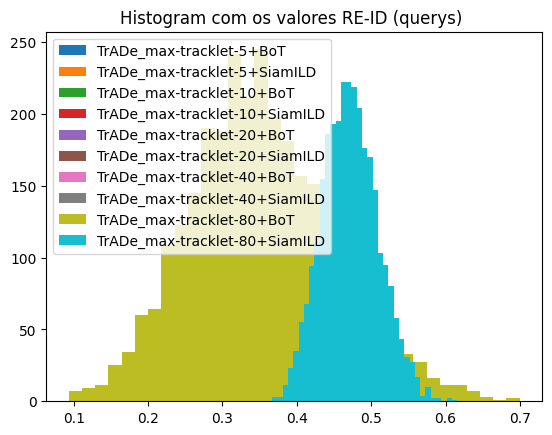

In [20]:

for curr_cosine, i in zip(all_cosine_similaritys, max_tracklets):
    hist_df_outcome_otherCam_trade_BoT     = plt.hist(curr_cosine[0], bins='auto',label='TrADe_max-tracklet-{}+BoT'.format(i))
    hist_df_outcome_otherCam_trade_Bot     = plt.hist(curr_cosine[1], bins='auto',label='TrADe_max-tracklet-{}+SiamILD'.format(i))
    plt.title("Histogram com os valores RE-ID (querys) ")
    plt.legend()

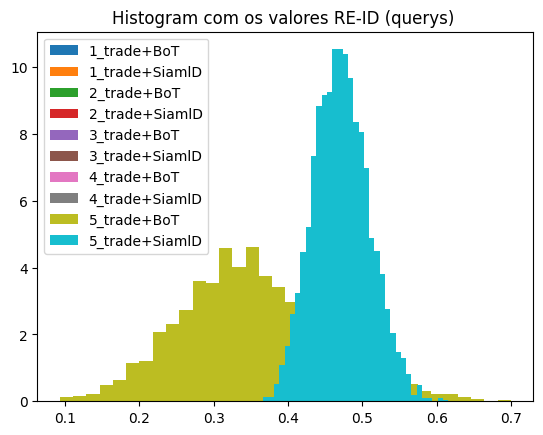

In [21]:
num = 1
for curr_cosine in all_cosine_similaritys:
    hist_df_outcome_otherCam_trade_BoT     = plt.hist(curr_cosine[0], density=True, bins='auto',label='{}_trade+BoT'.format(num))
    hist_df_outcome_otherCam_trade_Bot     = plt.hist(curr_cosine[1], density=True, bins='auto',label='{}_trade+SiamlD'.format(num))
    plt.title("Histogram com os valores RE-ID (querys) ")
    plt.legend()
    num+=1

## OPEN resultGUI dataframe

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.legend_handler import HandlerTuple

In [23]:
def request_data(df, beta, eta, tau):
    cond1 = (df['type']!='TrueSilence') & (df['beta']==beta) & (df['eta']==eta) & (df['tau']==tau)
    return df[cond1]

In [24]:
list_max_tracklet   = [5,10,20,40,80]
prefix_max_tracklet = 'size-tracklet-{}'


for i, (j, k) in zip(list_max_tracklet, all_dfs_resultGUI):
    print(prefix_max_tracklet.format(i))
    print( "BoT     ", j['type'].value_counts().to_dict())
    print( "SiamIDL ", k['type'].value_counts().to_dict())    

size-tracklet-5
BoT      {'TrueSilence': 3043, 'FalseCall': 2397, 'FalseSilence': 1606, 'TrueCall': 969, 'TrueMissedCall': 505}
SiamIDL  {'TrueSilence': 3069, 'FalseCall': 2371, 'FalseSilence': 1701, 'TrueCall': 939, 'TrueMissedCall': 440}
size-tracklet-10
BoT      {'TrueSilence': 3135, 'FalseCall': 2305, 'FalseSilence': 1661, 'TrueCall': 1065, 'TrueMissedCall': 354}
SiamIDL  {'TrueSilence': 3107, 'FalseCall': 2333, 'FalseSilence': 1726, 'TrueCall': 1047, 'TrueMissedCall': 307}
size-tracklet-20
BoT      {'TrueSilence': 3179, 'FalseCall': 2261, 'FalseSilence': 1682, 'TrueCall': 1194, 'TrueMissedCall': 204}
SiamIDL  {'TrueSilence': 3156, 'FalseCall': 2284, 'FalseSilence': 1763, 'TrueCall': 1037, 'TrueMissedCall': 280}
size-tracklet-40
BoT      {'TrueSilence': 3312, 'FalseCall': 2128, 'FalseSilence': 1794, 'TrueCall': 1186, 'TrueMissedCall': 100}
SiamIDL  {'TrueSilence': 3197, 'FalseCall': 2243, 'FalseSilence': 1791, 'TrueCall': 1204, 'TrueMissedCall': 85}
size-tracklet-80
BoT      {'True

In [25]:
# TrADe 2
# size-tracklet-5
# BoT      {'TrueSilence': 3043, 'FalseCall': 2397, 'FalseSilence': 1606, 'TrueCall': 969, 'TrueMissedCall': 505}
# SiamIDL  {'TrueSilence': 3069, 'FalseCall': 2371, 'FalseSilence': 1701, 'TrueCall': 939, 'TrueMissedCall': 440}
# size-tracklet-10
# BoT      {'TrueSilence': 3135, 'FalseCall': 2305, 'FalseSilence': 1661, 'TrueCall': 1065, 'TrueMissedCall': 354}
# SiamIDL  {'TrueSilence': 3107, 'FalseCall': 2333, 'FalseSilence': 1726, 'TrueCall': 1047, 'TrueMissedCall': 307}
# size-tracklet-20
# BoT      {'TrueSilence': 3179, 'FalseCall': 2261, 'FalseSilence': 1682, 'TrueCall': 1194, 'TrueMissedCall': 204}
# SiamIDL  {'TrueSilence': 3156, 'FalseCall': 2284, 'FalseSilence': 1763, 'TrueCall': 1037, 'TrueMissedCall': 280}
# size-tracklet-40
# BoT      {'TrueSilence': 3312, 'FalseCall': 2128, 'FalseSilence': 1794, 'TrueCall': 1186, 'TrueMissedCall': 100}
# SiamIDL  {'TrueSilence': 3197, 'FalseCall': 2243, 'FalseSilence': 1791, 'TrueCall': 1204, 'TrueMissedCall': 85}
# size-tracklet-80
# BoT      {'TrueSilence': 3458, 'FalseCall': 1982, 'FalseSilence': 1885, 'TrueCall': 1111, 'TrueMissedCall': 84}
# SiamIDL  {'TrueSilence': 3254, 'FalseCall': 2186, 'FalseSilence': 1813, 'TrueCall': 1097, 'TrueMissedCall': 170}

In [26]:
# TrADe 3
# BoT      {'TrueSilence': 3161, 'FalseCall': 2439, 'FalseSilence': 1666, 'TrueCall': 1034, 'TrueMissedCall': 460}
# SiamIDL  {'TrueSilence': 3156, 'FalseCall': 2444, 'FalseSilence': 1766, 'TrueCall': 940, 'TrueMissedCall': 454}
# BoT      {'TrueSilence': 3174, 'FalseCall': 2426, 'FalseSilence': 1690, 'TrueCall': 1176, 'TrueMissedCall': 294}
# SiamIDL  {'TrueSilence': 3189, 'FalseCall': 2411, 'FalseSilence': 1778, 'TrueCall': 1060, 'TrueMissedCall': 322}
# BoT      {'TrueSilence': 3307, 'FalseCall': 2293, 'FalseSilence': 1770, 'TrueCall': 1225, 'TrueMissedCall': 165}
# SiamIDL  {'TrueSilence': 3237, 'FalseCall': 2363, 'FalseSilence': 1806, 'TrueCall': 1114, 'TrueMissedCall': 240}
# BoT      {'TrueSilence': 3378, 'FalseCall': 2222, 'FalseSilence': 1846, 'TrueCall': 1198, 'TrueMissedCall': 115}
# SiamIDL  {'TrueSilence': 3271, 'FalseCall': 2329, 'FalseSilence': 1823, 'TrueCall': 1151, 'TrueMissedCall': 186}
# BoT      {'TrueSilence': 3464, 'FalseCall': 2136, 'FalseSilence': 1865, 'TrueCall': 1164, 'TrueMissedCall': 131}
# SiamIDL  {'TrueSilence': 3311, 'FalseCall': 2289, 'FalseSilence': 1853, 'TrueCall': 1112, 'TrueMissedCall': 195}

## FR  = TC / (TC + TMC + FS) 
## TVR = TC / (TC + TMC + FC)

In [27]:
def FR(dictTypes):
    tc  = dictTypes.get('TrueCall') if  dictTypes.get('TrueCall') else 0
    tmc = dictTypes.get('TrueMissedCall') if dictTypes.get('TrueMissedCall') else 0
    fs  = dictTypes.get('FalseSilence') if dictTypes.get('FalseSilence') else 0
    if tc==0:
        return 0
    if (tc + tmc + fs)==0:
        return 0
    return  tc / (tc + tmc + fs)

def TVR(dictTypes):
    tc  = dictTypes.get('TrueCall') if  dictTypes.get('TrueCall') else 0
    tmc = dictTypes.get('TrueMissedCall') if dictTypes.get('TrueMissedCall') else 0
    fc  = dictTypes.get('FalseCall') if dictTypes.get('FalseCall') else 0
    if tc==0:
        return 0
    if (tc + tmc + fc)==0:
        return 0
    return  tc / (tc + tmc + fc)

In [28]:
def linspace(start, end, step=1.):
    assert start<end, "start need greater than end"
#     epsilon = 0.000001
#     result = np.arange(start,end+epsilon,step)
    result = np.arange(start,end,step)
    result =  np.around(result, decimals=3)
    result = list(result)
    if result[-1]!=end:
        result.append(end)     
    return result


In [29]:
def processing_data(df, thrs_list, eta, tau):
#     tau        = 10  # [10,100,1000]
#     eta        = 10  #[10,20]
#     thrs_list  = [0.5, 0.6, 0.7, 0.8, 0.98]
    result_FR  = list() 
    result_TVR = list() 
    for thr in thrs_list:
        tmp_df   = request_data(df, thr, eta, tau)
        tmp_dict = tmp_df['type'].value_counts().to_dict()
        result_FR.append( FR(tmp_dict) )
        result_TVR.append( TVR(tmp_dict) )   
    return result_FR.copy(), result_TVR.copy()

In [30]:

# rc('mathtext', default='regular')

def plot_results(thrs_list, list_tuples, tau, eta, normalizeY=False, title=None, save_path=None):
    fig = plt.figure(figsize=(12,6))
    ax  = fig.add_subplot(111)
    if title:
        ax.set_title(title,y=1.15, pad=-14)

    ax2 = ax.twinx()

    ax.grid()
    ax.set_xlabel(r'Threshold ($\beta_i$)'+ '\n'+ 
                  r'Tau ($\tau='+str(tau)+'$)' + '\n'+
                  r'Eta ($\eta='+str(eta)+'$)'
                 )
    
    ax.set_ylabel(r'Finding Rate (FR)', color='blue')
    ax2.set_ylabel(r'True Validation Rate (TVR)', color='red')
    if normalizeY:
        ax.set_ylim(0, 1)
        ax2.set_ylim(0, 1)

    ###############################
    lines    = list()
    for j, j_point,k ,k_point ,lb , _alpha in list_tuples:
        min_size = min( len(thrs_list), len(j), len(k) )
        thrs_list= thrs_list[:min_size]
        j        = j[:min_size]
        k        = k[:min_size]
        ln1      = ax.plot(thrs_list, j, j_point, label = lb, alpha=_alpha , markersize = 10)
        ln2      = ax2.plot(thrs_list, k, k_point, label = lb , alpha=_alpha, markersize = 10)
        lines.append((ln1[0] , ln2[0]))
    # added these three lines
#     print(lines)
#     labels = [(l1.get_label(),l2.get_label()) for l1,l2 in lines]
    labels = [l1.get_label() for l1,l2 in lines]
    # ax.legend(lns, labs, loc=0)
#     print(labels)
#     print(len(lines)) 
    ax.legend(lines, labels,bbox_to_anchor=(0., 1.02, 1., .102), 
              loc='lower left', 
              ncol=len(lines), 
              mode="expand", 
              borderaxespad=0., 
              numpoints=1, 
              handler_map={tuple: HandlerTuple(ndivide=None)})
    if save_path:
        nameFigSave = '{}.png'
        if title:
            nameFigSave = nameFigSave.format(title)
        else:
            nameFigSave = nameFigSave.format('save_img')
        fig.savefig(os.path.join(save_path,nameFigSave),dpi=400)   # save the figure to file

#     plt.show()

In [31]:
def CalculateAveragePrecision(rec, prec):
    mrec = []
    mrec.append(0)
    [mrec.append(e) for e in rec]
    mrec.append(1)
    mpre = []
    mpre.append(0)
    [mpre.append(e) for e in prec]
    mpre.append(0)
    for i in range(len(mpre) - 1, 0, -1):
        mpre[i - 1] = max(mpre[i - 1], mpre[i])
    ii = []
    for i in range(len(mrec) - 1):
        if mrec[1+i] != mrec[i]:
            ii.append(i + 1)
    ap = 0
    for i in ii:
        ap = ap + np.sum((mrec[i] - mrec[i - 1]) * mpre[i])
    # return [ap, mpre[1:len(mpre)-1], mrec[1:len(mpre)-1], ii]
    return [ap, mpre[0:len(mpre) - 1], mrec[0:len(mpre) - 1], ii]

In [32]:
# thrs_list = linspace(start=0.2, end=0.98, step=0.02) 
thrs_list = linspace(start=0.2, end=0.6, step=0.02) 
# ETA rank (ex: 10, 20, 30)

In [33]:
all_FR_TVR = None
all_FR_TVR = list()

for curr_df in all_dfs_resultGUI:
    FR_trade_BoT,     TVR_trade_BoT     = processing_data(curr_df[0], thrs_list , eta=20, tau=1000 )
    FR_trade_SiamlDL, TVR_trade_SiamlDL = processing_data(curr_df[1], thrs_list , eta=20, tau=1000 )
    
    all_FR_TVR.append([[FR_trade_BoT ,    TVR_trade_BoT    ],
                       [FR_trade_SiamlDL, TVR_trade_SiamlDL],
                      ])

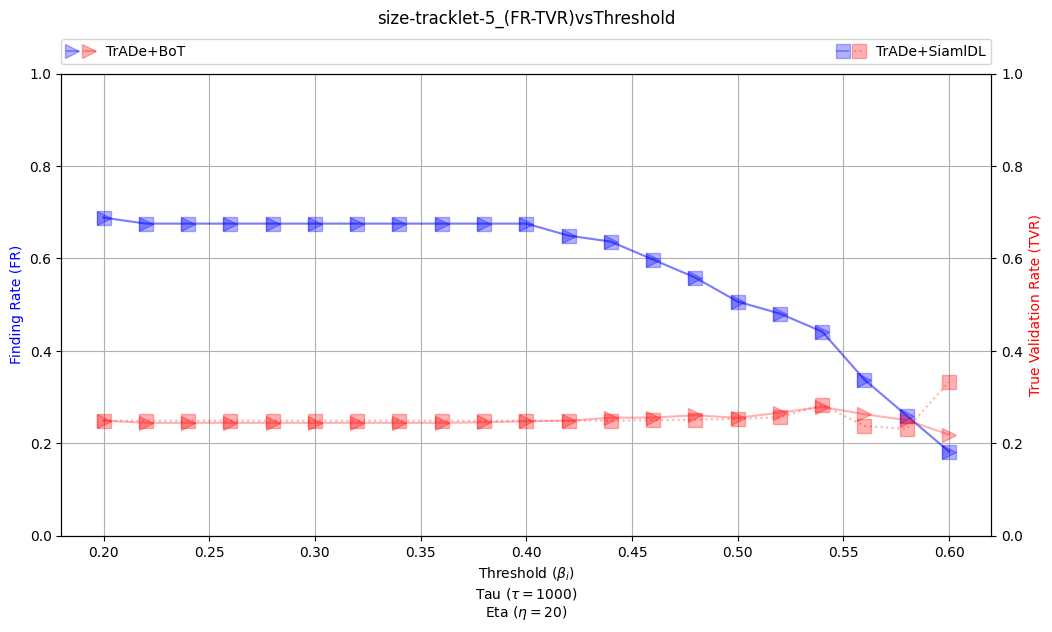

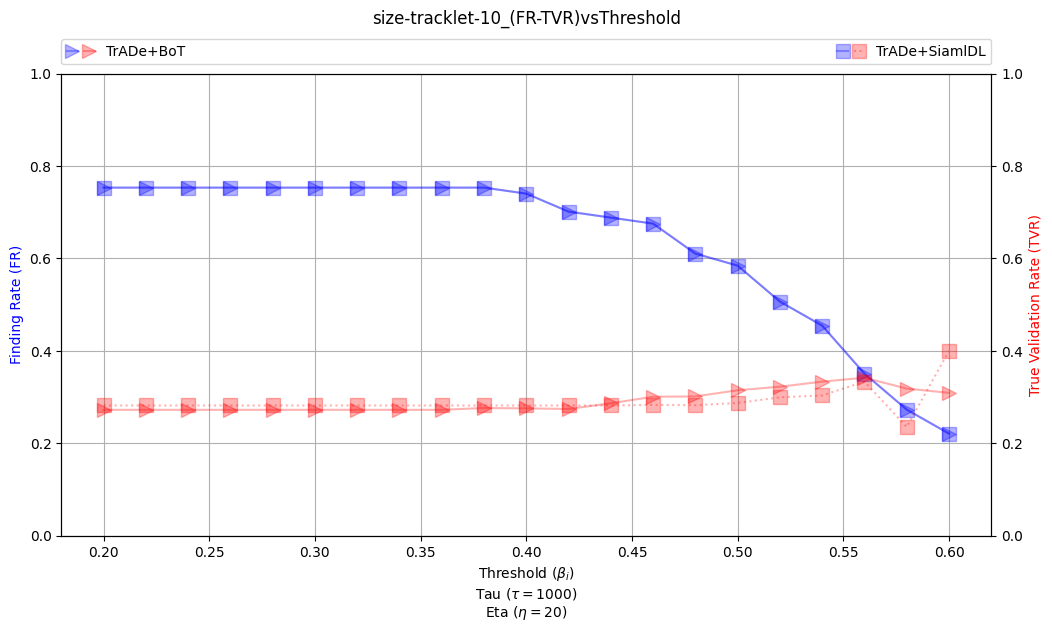

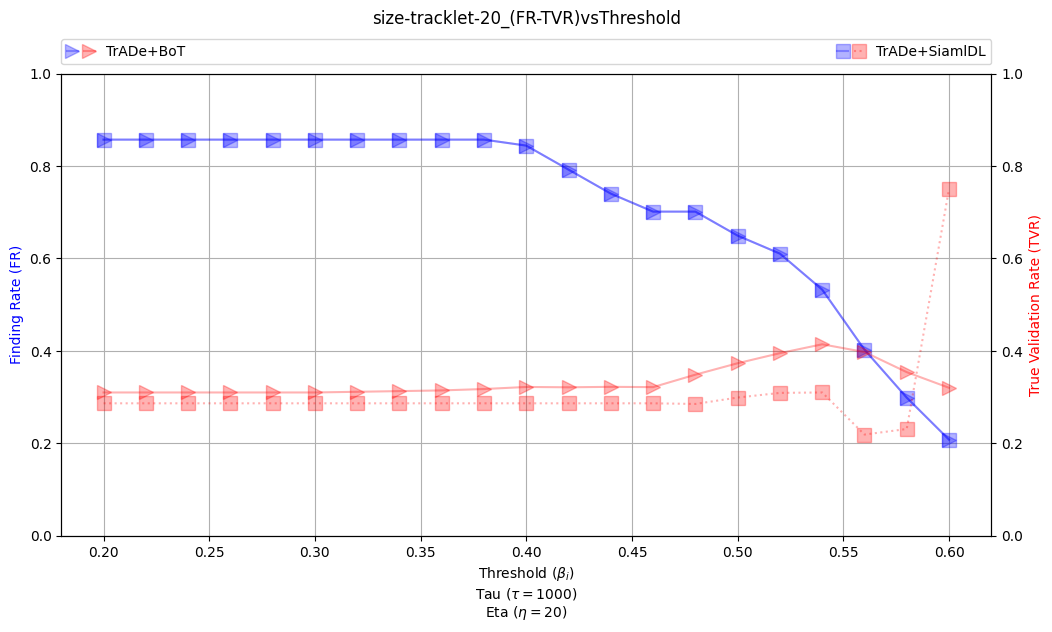

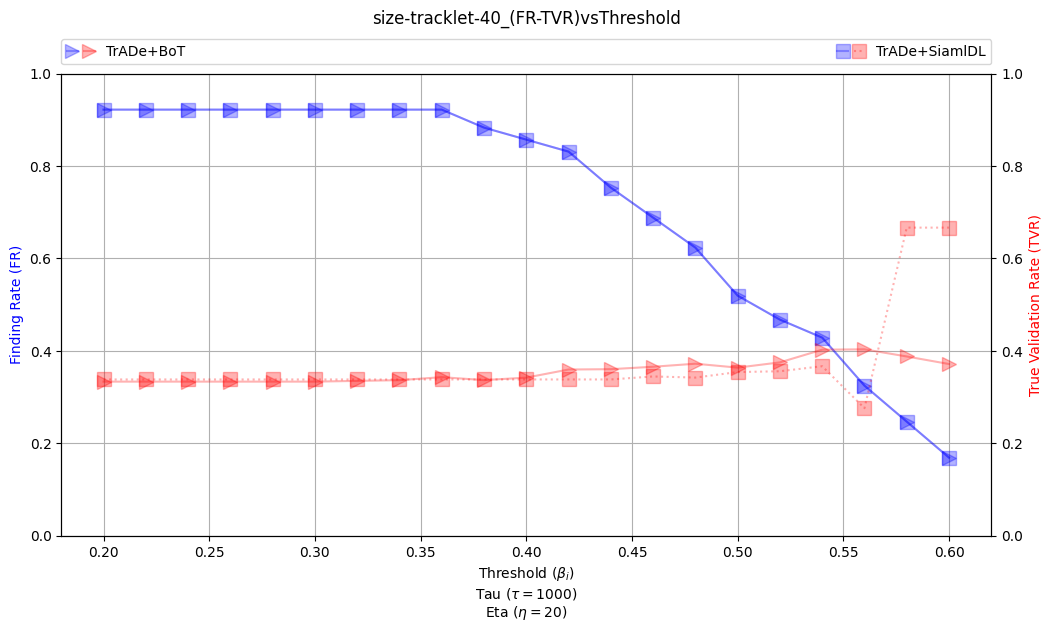

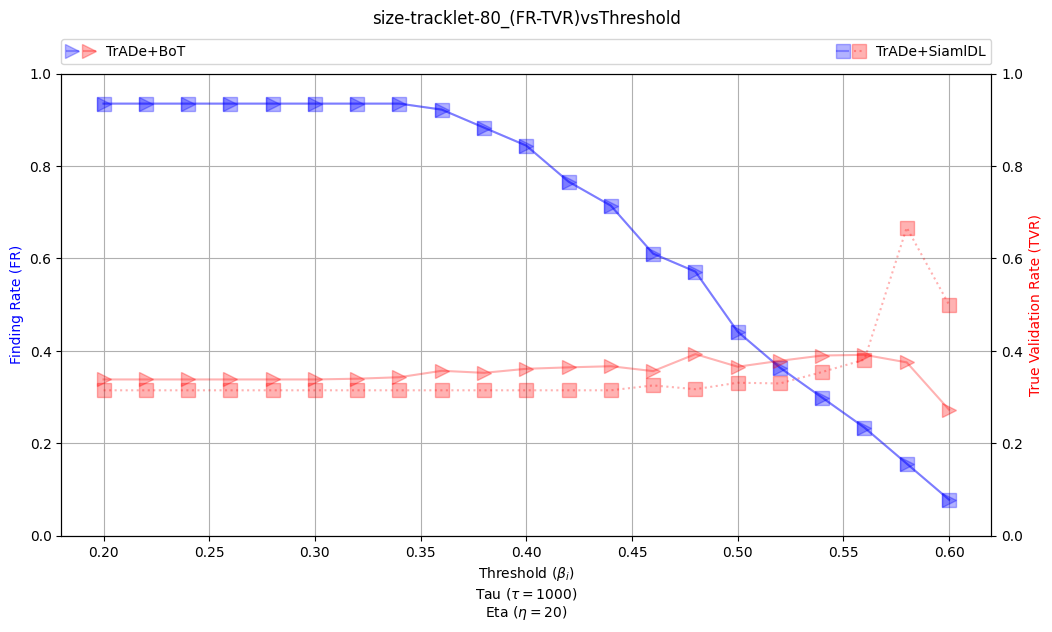

In [34]:

list_max_tracklet            = [5,10,20,40,80]
prefix_max_tracklet          = 'size-tracklet-{}'

count = 0
for (FR_BoT, TVR_BoT), (FR_SiamIDL, TVR_SiamIDL) in all_FR_TVR:
#     lines =[( FR_TVR[0][0],'>b-' ,FR_TVR[0][1], '>r-' , r'TrADe+BoT'        , 0.3 ),
#             ( FR_TVR[1][0],'sb-' ,FR_TVR[1][1], 'sr:' , r'TrADe+SiamlDL',  0.3) ]

    lines =[( FR_BoT,'>b-' ,TVR_BoT, '>r-' , r'TrADe+BoT'        , 0.3 ),
            ( FR_BoT,'sb-' ,TVR_SiamIDL, 'sr:' , r'TrADe+SiamlDL',  0.3) ]

    
    plot_results(thrs_list, 
                 lines, 
                 tau = 1000, 
                 eta = 20, 
                 normalizeY = True,
                 title      = prefix_max_tracklet.format(str(list_max_tracklet[count])+'_(FR-TVR)vsThreshold'),
                 save_path  = path_save_imgs,
                 )
    count+=1
    


## Finding max values FR and TVR from f-score

In [35]:
def average(listt):
    return sum(listt)/len(listt)

In [36]:
def FScore_v0(FR, TVR, gamma=1):
    _FR  = float(FR)
    _TVR = float(TVR)
    
    numerator   = float(1 + gamma**2) * (_FR * _TVR)
    denominator = ((float(gamma**2) * _FR) + _TVR)
    if denominator == 0:
        fs = 0
    else:
        fs = numerator / denominator
    return fs



In [37]:
import pandas
import numpy
from itertools import product


FR_TVR_results  = list()
tau             = [1000]

names_rows = ['TrADe+BoT','TrADe+SiamlDL']

for t_tau in tau:
    eta     = [20]
    cols1   = [5,10,20,40,80]
    cols2   = ['FR','TVR']
    tmp     = list(range(len(cols1)*len(cols2)))
    df      = pandas.DataFrame(columns=tmp)

    df.columns = pandas.MultiIndex.from_tuples(list(product(cols1, cols2)))
    df.insert(loc=0, column=('$\tau$ = {}, $\eta$ = {}'.format(t_tau, eta), 'Method'), value=names_rows)
    df.style.set_properties(**{'text-align': 'center'})

    FR_TVR_list = list()
    for i, j_curr_df in enumerate(all_dfs_resultGUI):
        iterate  = list(product(j_curr_df, eta))
#         print(iterate)
        tmp     = list()
        FR_list  = None
        TVR_list = None
        
        for i_df, j_eta in  iterate:
            FR_list, TVR_list = processing_data(i_df, thrs_list , eta=j_eta, tau=t_tau )
            fscores           = list()
            for i_FR, j_TVR in zip(FR_list, TVR_list):
                fs = FScore_v0(i_FR, j_TVR, gamma=1.0)
                fscores.append(fs)
            fs_max = max(fscores)
            idx    = fscores.index(fs_max)            
            
            tmp.append(FR_list[idx])
            tmp.append(TVR_list[idx])
        tmp = np.asarray(tmp).reshape(2,-1)
        df.iloc[0:2,(i*2)+1:(i*2)+3] = tmp
        
FR_TVR_results.append(df)

In [38]:
tmp_all_FR = list()
tmp_all_TVR = list()

for i,j in list(product([5,10,20,40,80],['FR'])):
    tmp_all_FR.append(FR_TVR_results[0][i][j])

for i,j in list(product([5,10,20,40,80],['TVR'])):
    tmp_all_TVR.append(FR_TVR_results[0][i][j])

new_all_FR_TVR = pd.concat(tmp_all_FR+tmp_all_TVR, join='outer', ignore_index=False, axis=1)
tmp_columns = list(product(['FR','TVR'],[5,10,20,40,80]))
new_all_FR_TVR.columns = pandas.MultiIndex.from_tuples(tmp_columns)
new_all_FR_TVR.insert(loc=0, column=('', '$_{\text{F-score}}$ / $^{\text{Max_tracklet}}$'), value=names_rows)
# display(new_all_FR_TVR)


In [39]:
max_new_all_FR_TVR = new_all_FR_TVR.copy()

In [40]:
max_new_all_FR_TVR

FR            \
  $_{\text{F-score}}$ / $^{\text{Max_tracklet}}$         5        10   
0                                      TrADe+BoT  0.688312  0.675325   
1                                  TrADe+SiamlDL  0.688312  0.779221   

                                      TVR                                \
         20        40        80         5        10        20        40   
0  0.610390  0.831169  0.922078  0.248826  0.300578  0.394958  0.359551   
1  0.792208  0.935065  0.857143  0.251185  0.283019  0.286385  0.344498   

             
         80  
0  0.356784  
1  0.325123

# plot FR vs TVR

In [41]:
max_new_all_FR_TVR

FR            \
  $_{\text{F-score}}$ / $^{\text{Max_tracklet}}$         5        10   
0                                      TrADe+BoT  0.688312  0.675325   
1                                  TrADe+SiamlDL  0.688312  0.779221   

                                      TVR                                \
         20        40        80         5        10        20        40   
0  0.610390  0.831169  0.922078  0.248826  0.300578  0.394958  0.359551   
1  0.792208  0.935065  0.857143  0.251185  0.283019  0.286385  0.344498   

             
         80  
0  0.356784  
1  0.325123

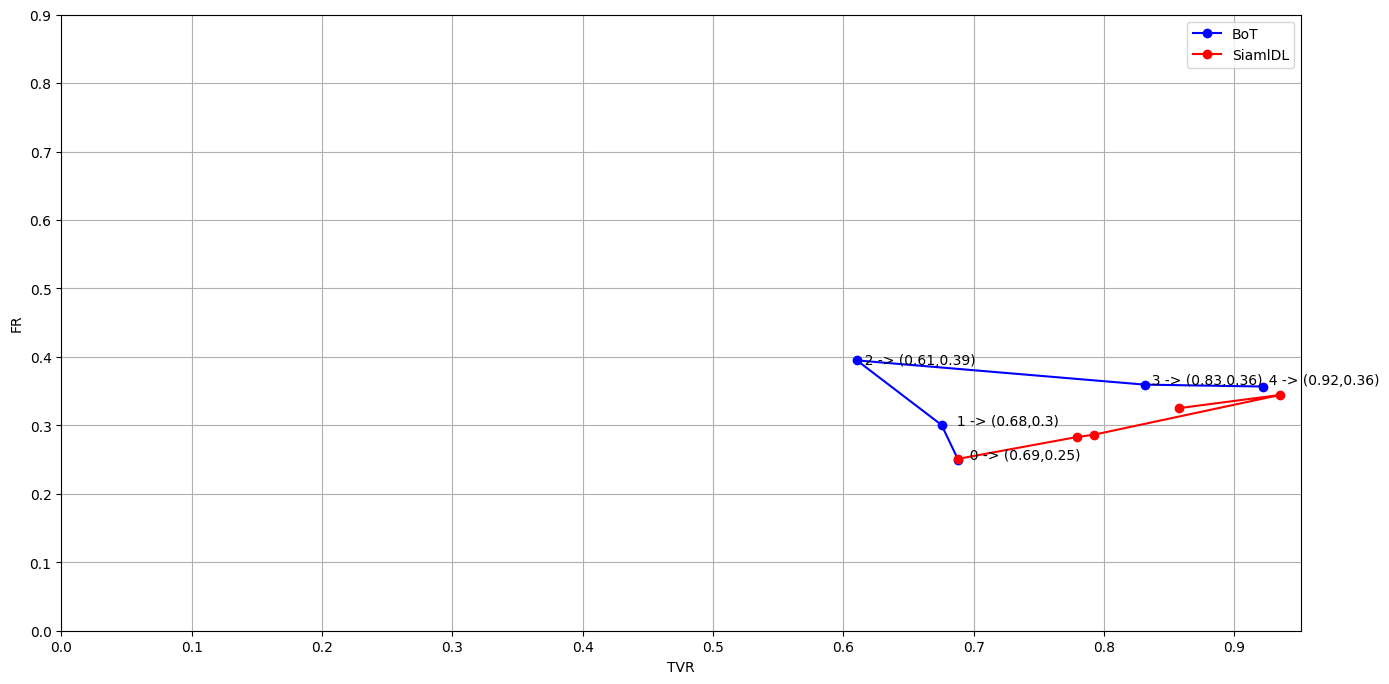

In [42]:
file_save = 'FR_vs_TVR'

plt.figure(figsize=(16, 8)) 

# axis_x1 = [1, 5, 10, 20, 40, 80]
# axis_x2 = [5, 10, 20, 40, 80]

axis_xx1 = max_new_all_FR_TVR['FR'].iloc[0].to_list()
axis_yy1 = max_new_all_FR_TVR['TVR'].iloc[0].to_list()

axis_xx2 = max_new_all_FR_TVR['FR'].iloc[1].to_list()
axis_yy2 = max_new_all_FR_TVR['TVR'].iloc[1].to_list()


plt.plot(axis_xx1, axis_yy1, 'bo-', label='BoT')
plt.plot(axis_xx2, axis_yy2, 'ro-', label='SiamlDL')

for i, (x,y) in enumerate(zip(axis_xx1, axis_yy1)):
    x = round(x,2)
    y = round(y,2)
    plt.annotate("  {} -> ({},{})".format(i,x,y), xy=(x,y))


plt.legend()
# plt.title('FR vs TVR')

plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 1, step=0.1))
# plt.xticks(axis_x1)

plt.grid(True)
plt.xlabel('TVR')
plt.ylabel('FR')


plt.grid(True)
# plt.savefig(os.path.join(path_save_imgs,file_save),dpi=400)   # save the figure to file

plt.show()
    

# plot Skip and TrADe max FR and TVR

### Plot max FR

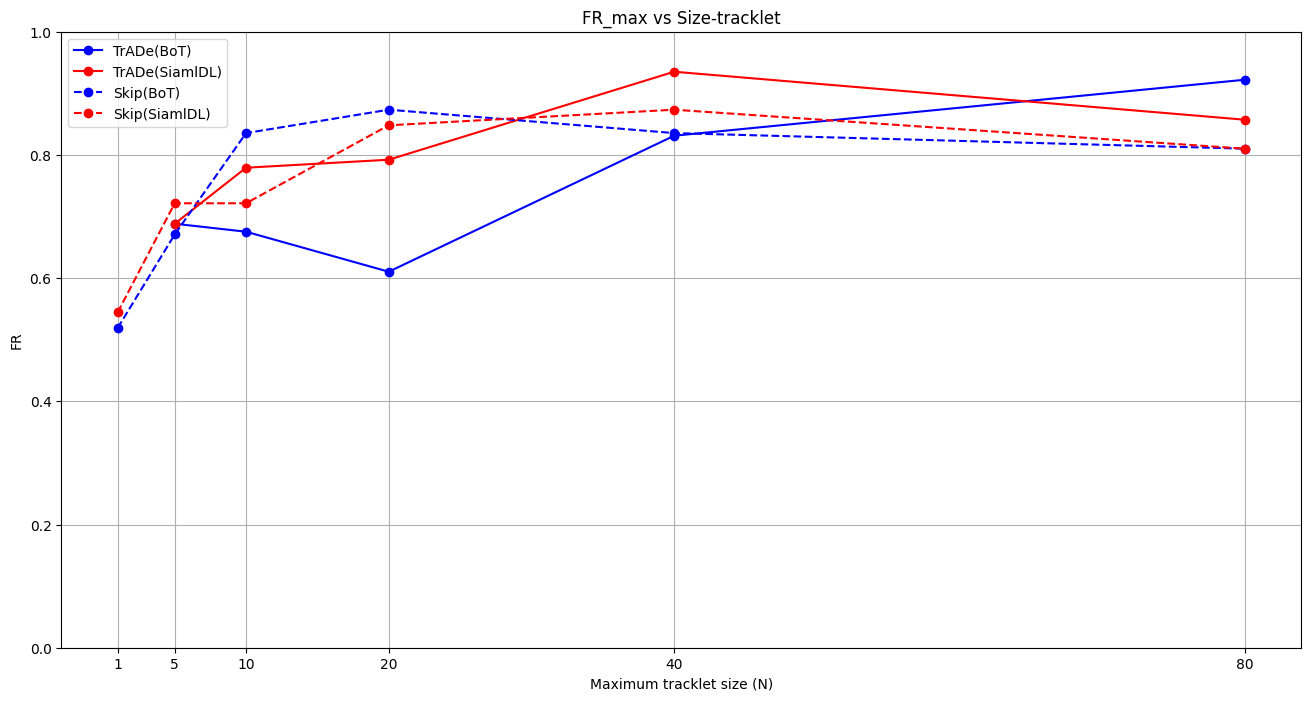

In [43]:
file_save = 'FR-max_SizeTracklet'

plt.figure(figsize=(16, 8)) 

axis_x1 = [1, 5, 10, 20, 40, 80]
axis_x2 = [5, 10, 20, 40, 80]

axis_y1 = new_all_FR_TVR['FR'].iloc[0].to_list()
axis_y2 = new_all_FR_TVR['FR'].iloc[1].to_list()


plt.plot(axis_x2, axis_y1, 'bo-', label='TrADe(BoT)')
plt.plot(axis_x2, axis_y2, 'ro-', label='TrADe(SiamlDL)')

axis_y3 = FR_TVR_results_Skip_max[0:6,1].astype(float).tolist()
axis_y4 = FR_TVR_results_Skip_max[6: ,1].astype(float).tolist()


plt.plot(axis_x1, axis_y3, 'bo--', label='Skip(BoT)')
plt.plot(axis_x1, axis_y4, 'ro--', label='Skip(SiamlDL)') 



plt.legend()
# plt.title('FR_mean vs Size-tracklet')
plt.title('FR_max vs Size-tracklet')
plt.yticks(np.arange(0.0, 1.01, step=0.2))
plt.xticks(np.arange(0, 90, step=10))
plt.xticks(axis_x1)

plt.xlabel('Maximum tracklet size (N)')
#     plt.ylabel('F-score ')
plt.ylabel("FR")


plt.grid(True)

plt.savefig(os.path.join(path_save_imgs,file_save),dpi=400)   # save the figure to file

plt.show()
    

### Plot max TVR

In [44]:
max_new_all_FR_TVR

FR            \
  $_{\text{F-score}}$ / $^{\text{Max_tracklet}}$         5        10   
0                                      TrADe+BoT  0.688312  0.675325   
1                                  TrADe+SiamlDL  0.688312  0.779221   

                                      TVR                                \
         20        40        80         5        10        20        40   
0  0.610390  0.831169  0.922078  0.248826  0.300578  0.394958  0.359551   
1  0.792208  0.935065  0.857143  0.251185  0.283019  0.286385  0.344498   

             
         80  
0  0.356784  
1  0.325123

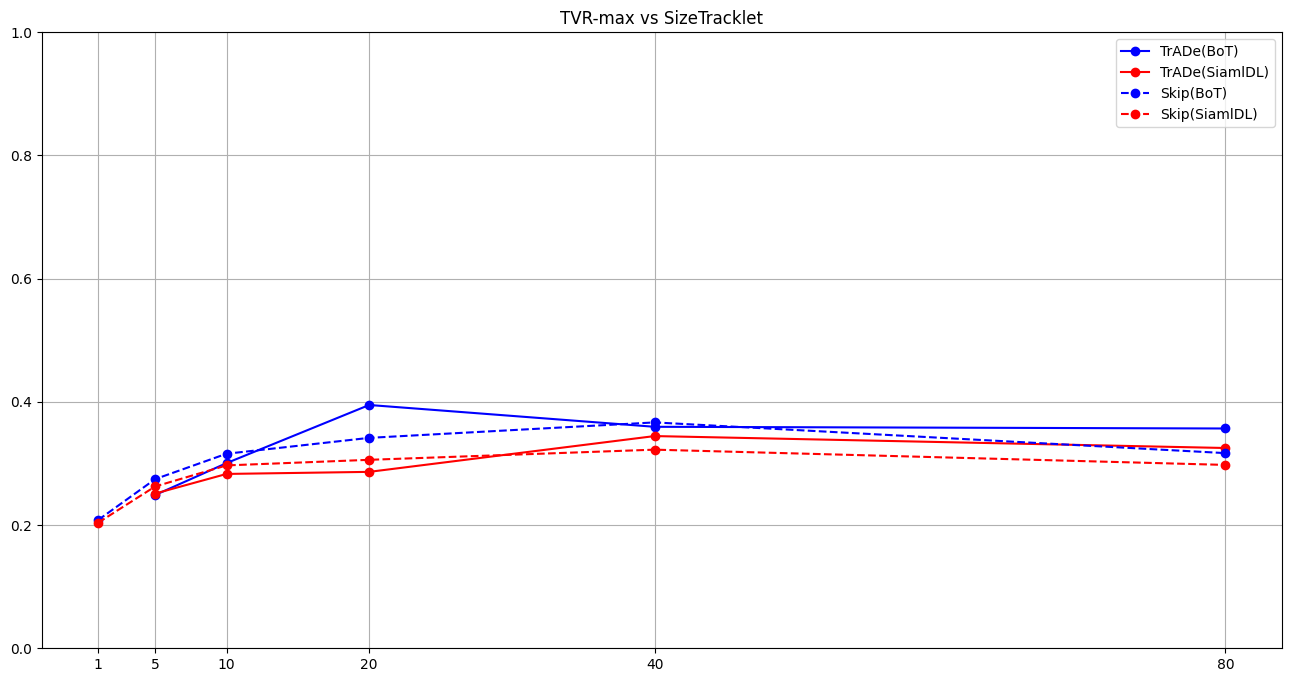

In [45]:
file_save = 'TVR-max_SizeTracklet'

plt.figure(figsize=(16, 8)) 

axis_x1 = [1, 5, 10, 20, 40, 80]
axis_x2 = [5, 10, 20, 40, 80]

axis_y1 = new_all_FR_TVR['TVR'].iloc[0].to_list()
axis_y2 = new_all_FR_TVR['TVR'].iloc[1].to_list()

plt.plot(axis_x2, axis_y1, 'bo-', label='TrADe(BoT)')
plt.plot(axis_x2, axis_y2, 'ro-', label='TrADe(SiamlDL)')

axis_y3 = FR_TVR_results_Skip_max[0:6,2].astype(float).tolist()
axis_y4 = FR_TVR_results_Skip_max[6: ,2].astype(float).tolist()

plt.plot(axis_x1, axis_y3, 'bo--', label='Skip(BoT)')
plt.plot(axis_x1, axis_y4, 'ro--', label='Skip(SiamlDL)') 


plt.legend()
# plt.title('TVR-mean vs SizeTracklet')
plt.title('TVR-max vs SizeTracklet')
plt.yticks(np.arange(0.0, 1.01, step=0.2))
# plt.xticks(np.arange(0, 90, step=10))
plt.xticks(axis_x1)

plt.grid(True)
# plt.savefig(os.path.join(path_save_imgs,file_save),dpi=400)   # save the figure to file

plt.show()
    

In [46]:
new_all_FR_TVR

FR            \
  $_{\text{F-score}}$ / $^{\text{Max_tracklet}}$         5        10   
0                                      TrADe+BoT  0.688312  0.675325   
1                                  TrADe+SiamlDL  0.688312  0.779221   

                                      TVR                                \
         20        40        80         5        10        20        40   
0  0.610390  0.831169  0.922078  0.248826  0.300578  0.394958  0.359551   
1  0.792208  0.935065  0.857143  0.251185  0.283019  0.286385  0.344498   

             
         80  
0  0.356784  
1  0.325123

## Values TVR

In [47]:
axis_Skip = [1, 5, 10, 20, 40, 80]
axis_TrADe = [5, 10, 20, 40, 80]

axis_y1 = new_all_FR_TVR['TVR'].iloc[0].to_list()
axis_y2 = new_all_FR_TVR['TVR'].iloc[1].to_list()

# plt.plot(axis_x2, axis_y1, 'bo-', label='TrADe(BoT)')
# plt.plot(axis_x2, axis_y2, 'ro-', label='TrADe(SiamlDL)')

axis_y3 = FR_TVR_results_Skip_max[0:6,2].astype(float).tolist()
axis_y4 = FR_TVR_results_Skip_max[6: ,2].astype(float).tolist()

# plt.plot(axis_x1, axis_y3, 'bo--', label='Skip(BoT)')
# plt.plot(axis_x1, axis_y4, 'ro--', label='Skip(SiamlDL)') 



print("TVR MAX")
print("============================")
print('TrADe(BoT)')
for i,j in zip(axis_TrADe, axis_y1):
    print("N={}".format(i),"{0:.3f}".format(j))

print(" ")
print('TrADe (SiamlDL)')
for i,j in zip(axis_TrADe, axis_y2):
    print("N={}".format(i),"{0:.3f}".format(j))
      
print("---------")
print('Skip (BoT)')
for i,j in zip(axis_Skip, axis_y3):
    print("N={}".format(i),"{0:.3f}".format(j))

print(" ")
print('Skip (SiamlDL)')
for i,j in zip(axis_Skip, axis_y4):
    print("N={}".format(i),"{0:.3f}".format(j))
print("---------")

TVR MAX
TrADe(BoT)
N=5 0.249
N=10 0.301
N=20 0.395
N=40 0.360
N=80 0.357
 
TrADe (SiamlDL)
N=5 0.251
N=10 0.283
N=20 0.286
N=40 0.344
N=80 0.325
---------
Skip (BoT)
N=1 0.208
N=5 0.275
N=10 0.316
N=20 0.342
N=40 0.367
N=80 0.317
 
Skip (SiamlDL)
N=1 0.204
N=5 0.263
N=10 0.297
N=20 0.306
N=40 0.322
N=80 0.298
---------


## Values FR

In [48]:
axis_Skip = [1, 5, 10, 20, 40, 80]
axis_TrADe = [5, 10, 20, 40, 80]

axis_y1 = new_all_FR_TVR['FR'].iloc[0].to_list()
axis_y2 = new_all_FR_TVR['FR'].iloc[1].to_list()

# plt.plot(axis_x2, axis_y1, 'bo-', label='TrADe(BoT)')
# plt.plot(axis_x2, axis_y2, 'ro-', label='TrADe(SiamlDL)')

axis_y3 = FR_TVR_results_Skip_max[0:6,1].astype(float).tolist()
axis_y4 = FR_TVR_results_Skip_max[6: ,1].astype(float).tolist()

# plt.plot(axis_x1, axis_y3, 'bo--', label='Skip(BoT)')
# plt.plot(axis_x1, axis_y4, 'ro--', label='Skip(SiamlDL)') 



print("FR MAX")
print("============================")
print('TrADe(BoT)')
for i,j in zip(axis_TrADe, axis_y1):
    print("N={}".format(i),"{0:.3f}".format(j))

print(" ")
print('TrADe (SiamlDL)')
for i,j in zip(axis_TrADe, axis_y2):
    print("N={}".format(i),"{0:.3f}".format(j))
      
print("---------")
print('Skip (BoT)')
for i,j in zip(axis_Skip, axis_y3):
    print("N={}".format(i),"{0:.3f}".format(j))

print(" ")
print('Skip (SiamlDL)')
for i,j in zip(axis_Skip, axis_y4):
    print("N={}".format(i),"{0:.3f}".format(j))
print("---------")

FR MAX
TrADe(BoT)
N=5 0.688
N=10 0.675
N=20 0.610
N=40 0.831
N=80 0.922
 
TrADe (SiamlDL)
N=5 0.688
N=10 0.779
N=20 0.792
N=40 0.935
N=80 0.857
---------
Skip (BoT)
N=1 0.519
N=5 0.671
N=10 0.835
N=20 0.873
N=40 0.835
N=80 0.810
 
Skip (SiamlDL)
N=1 0.544
N=5 0.722
N=10 0.722
N=20 0.848
N=40 0.873
N=80 0.810
---------


# Calculate Average Precision (AP)

In [49]:
import pandas
import numpy
from itertools import product


ap_results = list()
tau        = [1000]

names_rows = ['TrADe+BoT','TrADe+SiamlDL']


for curr_df in all_dfs_resultGUI:
    for _tau in tau:
        eta   = [20]
        cols1 = ['AP']
        cols2 = ['$\eta$={}'.format(eta[0]),
                ]
        tmp   = list(range(len(cols1)*len(cols2)))
        df = pandas.DataFrame(columns=tmp)

        df.columns = pandas.MultiIndex.from_tuples(list(product( cols1, cols2)))
        df.insert(loc=0, column=('$\tau$ = {}'.format(_tau), 'Method'), value=names_rows)
        # df.style.set_properties(**{'text-align': 'center'})

        iterate  = list(product(curr_df, eta))
        list_tmp = list()
        for _df, _eta in  iterate:
            _recall, _precision  = processing_data(_df, thrs_list , eta=_eta, tau=_tau )
            _recall, _precision  = _recall[::-1], _precision[::-1]
            [ap, mpre, mrec, ii] = CalculateAveragePrecision(_recall, _precision)
            list_tmp.append(ap)

        list_tmp       = np.asarray(list_tmp)
        list_tmp       = list_tmp.reshape(2,1)
        df.iloc[:,1:2] = list_tmp
        ap_results.append(df)

# post-processing

from functools import reduce
new_df = [i[['AP']] for i in ap_results]
all_aps = pd.concat(new_df, join='outer', ignore_index=False, axis=1)
# all_results.columns.to_list()
new_columns = list(product([5,10,20,40,80],['$\\eta$=20']))
all_aps.columns = pandas.MultiIndex.from_tuples(new_columns)
all_aps.insert(loc=0, column=('$_{\text{AP}}$ / $^{\text{Max_tracklet}}$', 'Method'), value=names_rows)


In [50]:
all_aps

,$_{\text{AP}}$ / $^{\text{Max_tracklet}}$,5,10,20,40,80
,Method,$\eta$=20,$\eta$=20,$\eta$=20,$\eta$=20,$\eta$=20
0,TrADe+BoT,0.186561,0.244737,0.334028,0.351654,0.356183
1,TrADe+SiamlDL,0.188125,0.239774,0.257686,0.348720,0.301567


# F-score

Fγ = (1 + γ^2) * (FR * TVR) / ((γ^2 * FR) + TVR)

In [51]:
def FScore(FR, TVR, gamma=1):
    _FR  = float(FR)
    _TVR = float(TVR)
    
    numerator   = float(1 + gamma**2) * (_FR * _TVR)
    denominator = ((float(gamma**2) * _FR) + _TVR)
    if denominator == 0:
        fs = 0
    else:
        fs = numerator / denominator
    return fs



In [52]:
def processing_data2(df, thrs_list, eta, tau):
#     tau        = 10  # [10,100,1000]
#     eta        = 10  #[10,20]
#     thrs_list  = [0.5, 0.6, 0.7, 0.8, 0.98]
    result_FR  = list() 
    result_TVR = list() 
    for thr in thrs_list:
        tmp_df   = request_data(df, thr, eta, tau)
        tmp_dict = tmp_df['type'].value_counts().to_dict()
        result_FR.append( FR(tmp_dict) )
        result_TVR.append( TVR(tmp_dict) )   
    return result_FR.copy(), result_TVR.copy()

In [53]:
import pandas
import numpy
from itertools import product


FR_TVR_results  = list()
tau             = [1000]

names_rows = ['TrADe+BoT','TrADe+SiamlDL']

for t_tau in tau:
    eta     = [20]
    cols1   = [5,10,20,40,80]
    cols2   = ['FR','TVR']
    tmp     = list(range(len(cols1)*len(cols2)))
    df      = pandas.DataFrame(columns=tmp)

    df.columns = pandas.MultiIndex.from_tuples(list(product(cols1, cols2)))
    df.insert(loc=0, column=('$\tau$ = {}, $\eta$ = {}'.format(t_tau, eta), 'Method'), value=names_rows)
    df.style.set_properties(**{'text-align': 'center'})

    FR_TVR_list = list()
    for i, j_curr_df in enumerate(all_dfs_resultGUI):
        iterate  = list(product(j_curr_df, eta))
#         print(iterate)
        tmp     = list()
        FR_list  = None
        TVR_list = None
        
        for i_df, j_eta in  iterate:
            FR_list, TVR_list = processing_data(i_df, thrs_list , eta=j_eta, tau=t_tau )
            tmp.append(max(FR_list))
            tmp.append(max(TVR_list))
        tmp = np.asarray(tmp).reshape(2,-1)
        df.iloc[0:2,(i*2)+1:(i*2)+3] = tmp
        
FR_TVR_results.append(df)

In [54]:
import pandas
import numpy
from itertools import product

fscore05 = '$F_{\gamma=0.5}$ Score'
fscore10 = '$F_{\gamma=1.0}$ Score'
fscore20 = '$F_{\gamma=2.0}$ Score'

fscore_results = list()
tau            = [1000]

names_rows = ['TrADe+BoT','TrADe+SiamlDL']

for curr_df in all_dfs_resultGUI:
    for _tau in tau:
        eta     = [20]
        cols1   = [fscore05, fscore10, fscore20]
#         cols1   = ['F=0.5Score', 'F=1.0Score', 'F=2.0Score']
        gammas  = [0.5, 1, 2]
        cols2   = ['$\eta$={}'.format(eta[0]),
                  ]
        tmp = list(range(len(eta)*len(gammas)))
        df  = pandas.DataFrame(columns=tmp)

        df.columns = pandas.MultiIndex.from_tuples(list(product(cols1, cols2)))
        df.insert(loc=0, column=('$\tau$ = {}'.format(_tau), 'Method'), value=names_rows)
        # df.style.set_properties(**{'text-align': 'center'})

        iterate  = list(product(curr_df, gammas, eta))
        list_tmp = list()
        for i_df, _gamma, j_eta in  iterate:
            FR_list, TVR_list  = processing_data2(i_df, thrs_list , eta=j_eta, tau=_tau )
            fscores = list()
            
#             max_FR  = max(FR_list)
#             max_TVR = max(TVR_list)
#             fs_max  = FScore(max_FR, max_TVR, gamma=_gamma)

            for i_FR, j_TVR in zip(FR_list, TVR_list):
                fs = FScore(i_FR, j_TVR, gamma=_gamma)
                fscores.append(fs)
            fs_max = max(fscores)
            list_tmp.append(fs_max)

        list_tmp = np.asarray(list_tmp)
        list_tmp = list_tmp.reshape(2,3)
        df.iloc[:,1:4] = list_tmp
        fscore_results.append(df)

        # post-processing

from functools import reduce
new_df_fscore = [i.iloc[:,1:4] for i in fscore_results]

all_fscores = pd.concat(new_df_fscore, join='outer', ignore_index=False, axis=1)
# cols1   = ['$F_{\gamma=0.5}$ Score', '$F_{\gamma=1.0}$ Score', '$F_{\gamma=2.0}$ Score']
# new_columns = list(product([5,10,20,40,80],['F=0.5Score','F=1.0Score','F=2.0Score']))
new_columns = list(product([5,10,20,40,80],[fscore05, fscore10, fscore20]))
all_fscores.columns = pandas.MultiIndex.from_tuples(new_columns)
all_fscores.insert(loc=0, column=('$_{\text{F-score}}$ / $^{\text{Max_tracklet}}$', 'Method'), value=names_rows)


In [55]:
all_fscores

$_{\text{F-score}}$ / $^{\text{Max_tracklet}}$                      5  \
                                          Method $F_{\gamma=0.5}$ Score   
0                                      TrADe+BoT               0.508637   
1                                  TrADe+SiamlDL               0.510597   

                                                                    10  \
  $F_{\gamma=1.0}$ Score $F_{\gamma=2.0}$ Score $F_{\gamma=0.5}$ Score   
0               0.365517               0.300885               0.559846   
1               0.368056               0.299401               0.576923   

                                                                    20  \
  $F_{\gamma=1.0}$ Score $F_{\gamma=2.0}$ Score $F_{\gamma=0.5}$ Score   
0               0.416000               0.352113               0.639535   
1               0.415225               0.330827               0.585413   

                                                                    40  \
  $F_{\gamma=1.0}$ Score $F_{\gamma=2.0}$ Score $F_{\gamma=0.5}$ Score   
0               0.479592               0.433404               0.689320   
1               0.420690               0.336352               0.696325   

                                                                    80  \
  $F_{\gamma=1.0}$ Score $F_{\gamma=2.0}$ Score $F_{\gamma=0.5}$ Score   
0               0.501961               0.407407               0.700197   
1               0.503497               0.395284               0.645793   

                                                 
  $F_{\gamma=1.0}$ Score $F_{\gamma=2.0}$ Score  
0               0.514493               0.419048  
1               0.471429               0.371204

In [56]:
tmp_all_fscores = list()
for i,j in list(product([fscore05,fscore10,fscore20],[5,10,20,40,80])):
    tmp_all_fscores.append(all_fscores[j][i])

In [57]:
names_rows = ['trade+BoT','trade+SiamlDL']

In [58]:
new_all_fscores = pd.concat(tmp_all_fscores, join='outer', ignore_index=False, axis=1)

tmp_columns = list(product([fscore05, fscore10, fscore20],[5,10,20,40,80]))
new_all_fscores.columns = pandas.MultiIndex.from_tuples(tmp_columns)
new_all_fscores.insert(loc=0, column=('', '$_{\text{F-score}}$ / $^{\text{Max_tracklet}}$'), value=names_rows)


In [59]:
new_all_fscores

$F_{\gamma=0.5}$ Score  \
  $_{\text{F-score}}$ / $^{\text{Max_tracklet}}$                      5   
0                                      trade+BoT               0.508637   
1                                  trade+SiamlDL               0.510597   

                                          $F_{\gamma=1.0}$ Score            \
         10        20        40        80                      5        10   
0  0.559846  0.639535  0.689320  0.700197               0.365517  0.416000   
1  0.576923  0.585413  0.696325  0.645793               0.368056  0.415225   

                                $F_{\gamma=2.0}$ Score                      \
         20        40        80                      5        10        20   
0  0.479592  0.501961  0.514493               0.300885  0.352113  0.433404   
1  0.420690  0.503497  0.471429               0.299401  0.330827  0.336352   

                       
         40        80  
0  0.407407  0.419048  
1  0.395284  0.371204


# PLOT   F-Score

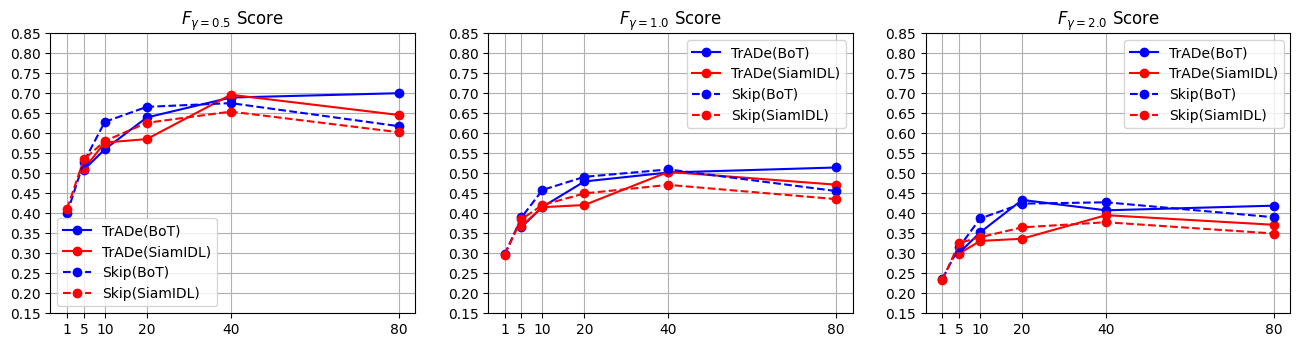

In [60]:
count = 1
plt.figure(figsize=(16, 8)) 

axis_Skip  = [1, 5, 10, 20, 40, 80]
axis_TrADe = [5, 10, 20, 40, 80]


for i, fs_i in enumerate([fscore05,fscore10,fscore20]):
    plt.subplot(2, 3, count)

    axis_y1 = new_all_fscores[fs_i].iloc[0].to_list()
    axis_y2 = new_all_fscores[fs_i].iloc[1].to_list()
    axis_y3 = data_fscores_classic_reid_BoT[:,i+1].astype(float).tolist()
    axis_y4 = data_fscores_classic_reid_SiamlDL[:,i+1].astype(float).tolist()

    plt.plot(axis_TrADe, axis_y1, 'bo-', label='TrADe(BoT)')
    plt.plot(axis_TrADe, axis_y2, 'ro-', label='TrADe(SiamIDL)')

    
    plt.plot(axis_Skip, axis_y3, 'bo--', label='Skip(BoT)')
    plt.plot(axis_Skip, axis_y4, 'ro--', label='Skip(SiamIDL)') 
 

    plt.legend()
    plt.title(fs_i)
    plt.yticks(np.arange(0.15, 0.9, step=0.05))
    plt.xticks(np.arange(0, 90, step=10))
    plt.xticks(axis_x1)
    
    plt.grid(True)
    count+=1

plt.show()
    

# Plot images to big font

In [61]:
new_all_fscores

$F_{\gamma=0.5}$ Score  \
  $_{\text{F-score}}$ / $^{\text{Max_tracklet}}$                      5   
0                                      trade+BoT               0.508637   
1                                  trade+SiamlDL               0.510597   

                                          $F_{\gamma=1.0}$ Score            \
         10        20        40        80                      5        10   
0  0.559846  0.639535  0.689320  0.700197               0.365517  0.416000   
1  0.576923  0.585413  0.696325  0.645793               0.368056  0.415225   

                                $F_{\gamma=2.0}$ Score                      \
         20        40        80                      5        10        20   
0  0.479592  0.501961  0.514493               0.300885  0.352113  0.433404   
1  0.420690  0.503497  0.471429               0.299401  0.330827  0.336352   

                       
         40        80  
0  0.407407  0.419048  
1  0.395284  0.371204

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


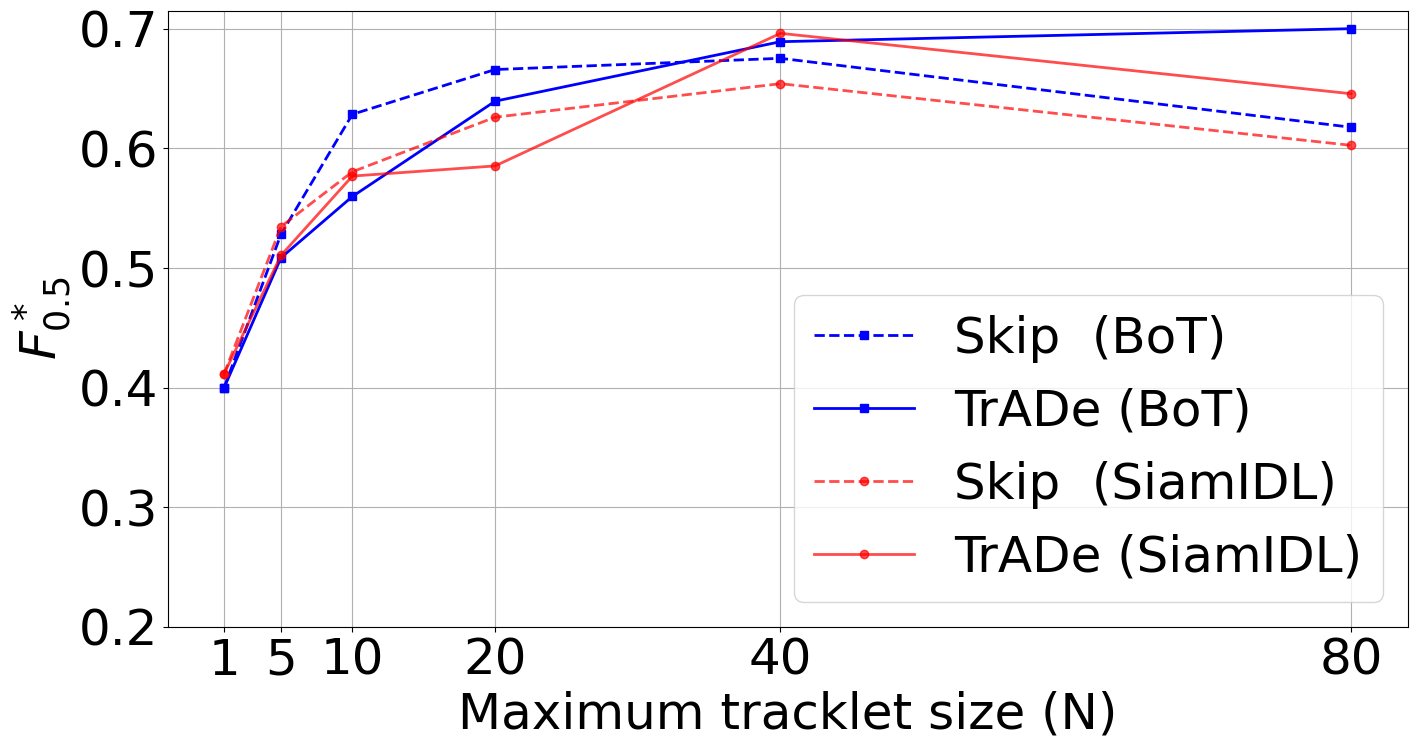

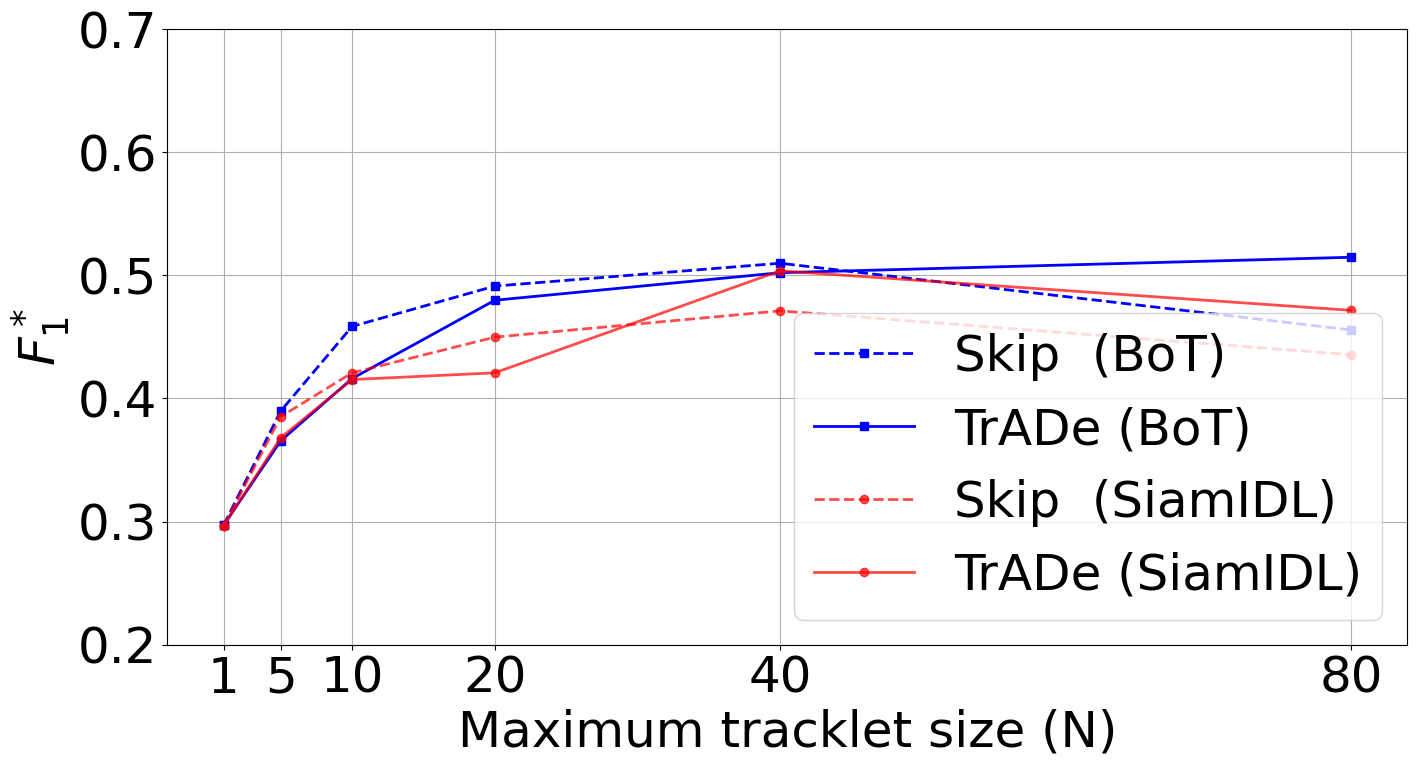

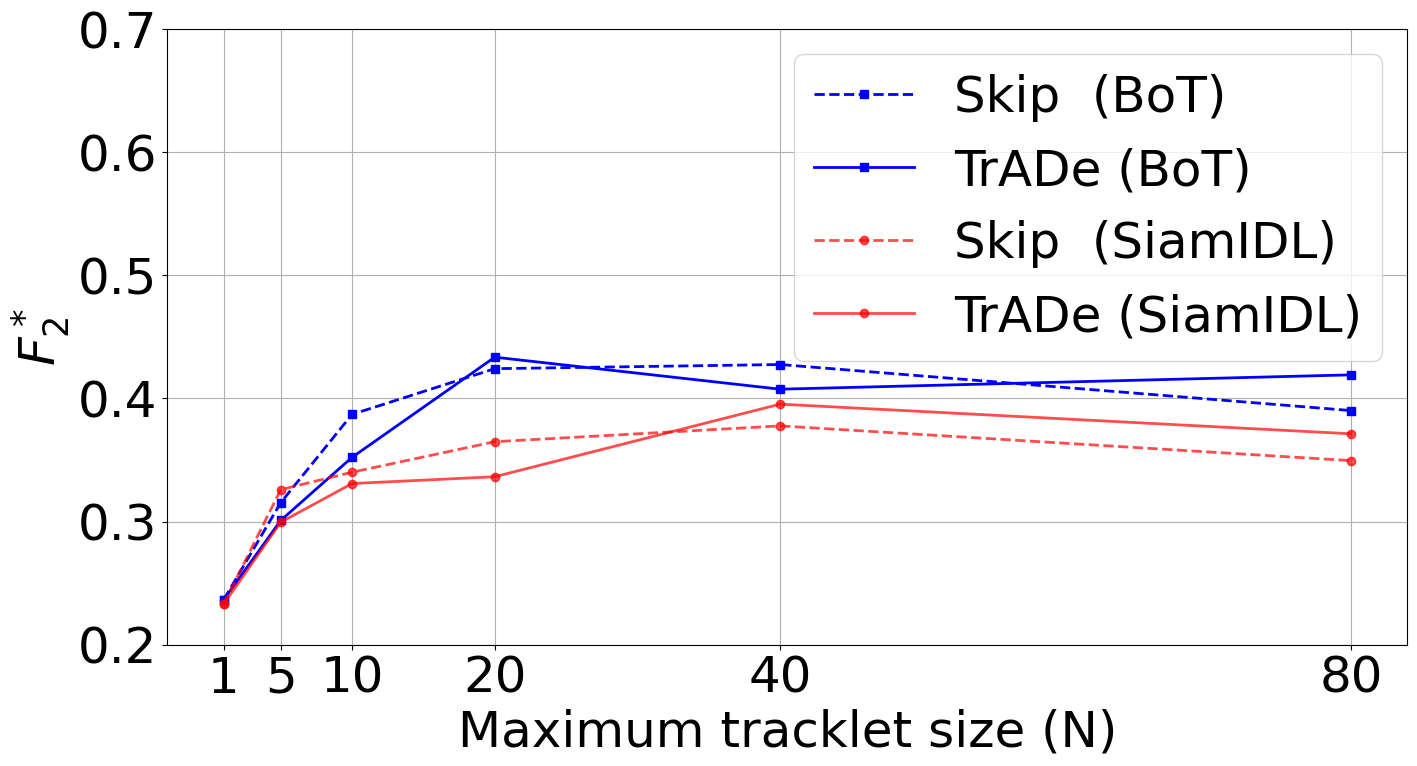

In [62]:

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times New Roman'], 'size':36 })
rc('text', usetex=False)

axis_Skip  = [1, 5, 10, 20, 40, 80]
axis_TrADe = [5, 10, 20, 40, 80]


title_fscores = ["$F^*_{0.5}$","$F^*_{1}$","$F^*_{2}$"]
for i, fs_i in enumerate([fscore05,fscore10,fscore20]):
    plt.figure(figsize=(16, 8))
    
    axis_y1 = list([data_fscores_classic_reid_BoT[:,i+1].astype(float).tolist()[0]]     + new_all_fscores[fs_i].iloc[0].to_list())
    axis_y2 = list([data_fscores_classic_reid_SiamlDL[:,i+1].astype(float).tolist()[0]] + new_all_fscores[fs_i].iloc[1].to_list())
    
    axis_y3 = data_fscores_classic_reid_BoT[:,i+1].astype(float).tolist()
    axis_y4 = data_fscores_classic_reid_SiamlDL[:,i+1].astype(float).tolist()

    plt.plot(axis_Skip, axis_y3, 'bs--', label='Skip  (BoT)'    ,alpha=1, linewidth=2)
    plt.plot(axis_Skip, axis_y1, 'bs-',  label='TrADe (BoT)'    ,alpha=1, linewidth=2)

    plt.plot(axis_Skip, axis_y4, 'ro--', label='Skip  (SiamIDL)' ,alpha=0.7, linewidth=2) 
    plt.plot(axis_Skip, axis_y2, 'ro-',  label='TrADe (SiamIDL)' ,alpha=0.7, linewidth=2)

    
    plt.legend()
#     plt.title(fs_i)
    plt.yticks(np.arange(0.20, 0.71, step=0.1))
#     plt.xticks(np.arange(0, 90, step=10))
    plt.xticks(axis_x1)
    
    plt.grid(True)
    
    nameFigSave = '{}.png'
    nameFigSave = nameFigSave.format(fs_i)
    plt.xlabel('Maximum tracklet size (N)')
#     plt.ylabel('F-score ')
    plt.ylabel(title_fscores[i])

    plt.savefig(os.path.join(path_save_imgs,nameFigSave))   # save the figure to file
    plt.show()
    

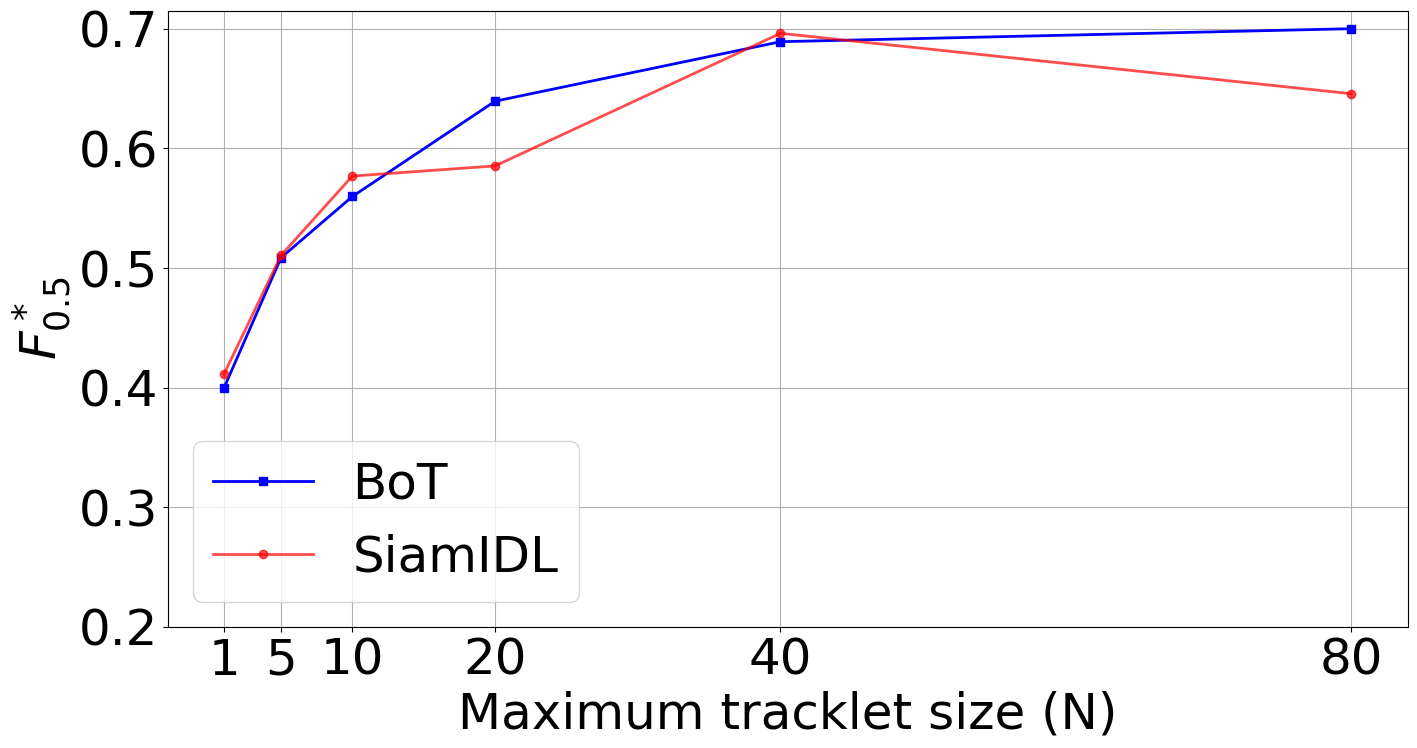

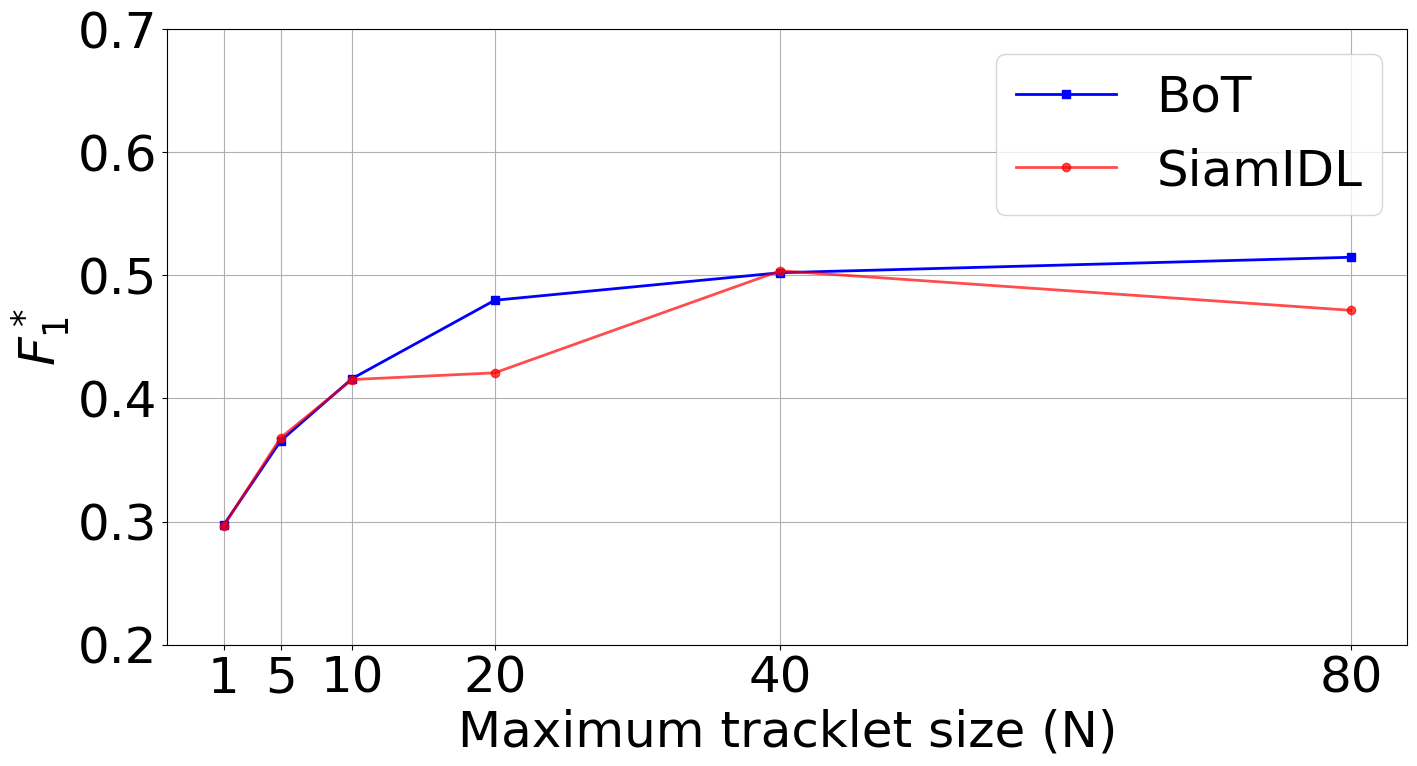

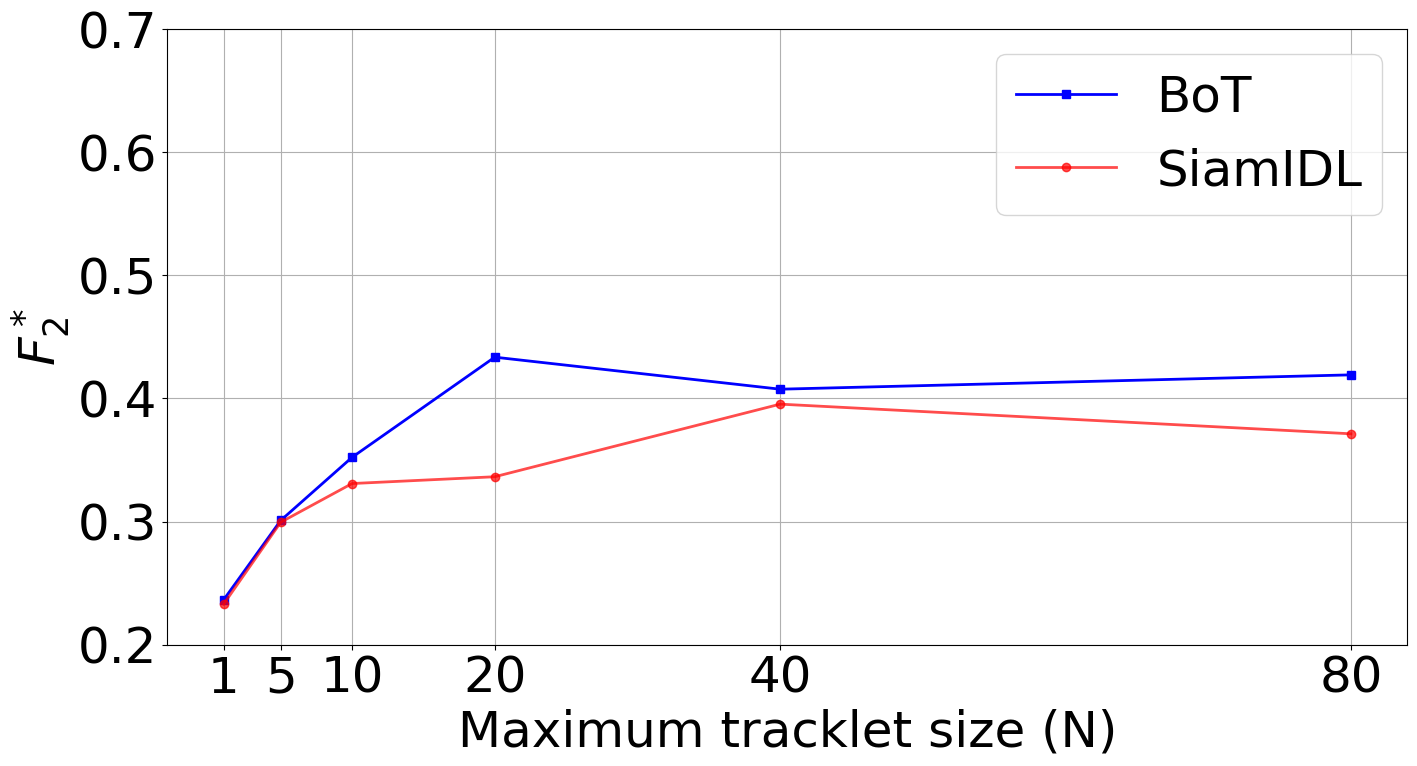

In [63]:

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times New Roman'], 'size':36 })
rc('text', usetex=False)


title_fscores = ["$F^*_{0.5}$","$F^*_{1}$","$F^*_{2}$"]
nameSaveFscore = ["F_05_Score","F_10_Score","F_20_Score"]

axis_Skip  = [1, 5, 10, 20, 40, 80]
axis_TrADe = [5, 10, 20, 40, 80]

for i, fs_i in enumerate([fscore05,fscore10,fscore20]):
    plt.figure(figsize=(16, 8))

    axis_y1 = list([data_fscores_classic_reid_BoT[:,i+1].astype(float).tolist()[0]]     + new_all_fscores[fs_i].iloc[0].to_list())
    axis_y2 = list([data_fscores_classic_reid_SiamlDL[:,i+1].astype(float).tolist()[0]] + new_all_fscores[fs_i].iloc[1].to_list())
    
    axis_y3 = data_fscores_classic_reid_BoT[:,i+1].astype(float).tolist()
    axis_y4 = data_fscores_classic_reid_SiamlDL[:,i+1].astype(float).tolist()

#     plt.plot(axis_Skip, axis_y3, 'bs--', label='Skip  (BoT)'    ,alpha=1, linewidth=2)
    plt.plot(axis_Skip, axis_y1, 'bs-',  label='BoT'    ,alpha=1, linewidth=2)

#     plt.plot(axis_Skip, axis_y4, 'ro--', label='Skip  (SiamIDL)' ,alpha=0.7, linewidth=2) 
    plt.plot(axis_Skip, axis_y2, 'ro-',  label='SiamIDL' ,alpha=0.7, linewidth=2)
   
    
    plt.legend()
#     plt.title(fs_i)
    plt.yticks(np.arange(0.20, 0.71, step=0.1))
#     plt.xticks(np.arange(0, 90, step=10))
    plt.xticks(axis_x1)
    
    plt.grid(True)
    
    nameFigSave = '{}.png'
    nameFigSave = nameFigSave.format(nameSaveFscore[i])
    plt.xlabel('Maximum tracklet size (N)')
#     plt.ylabel('F-score ')
    plt.ylabel(title_fscores[i])

    plt.savefig(os.path.join(path_save_imgs,nameFigSave))   # save the figure to file
    plt.show()
    

# PLOT Average Precision

In [64]:

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times New Roman'], 'size':36 })
rc('text', usetex=False)



axis_Skip = [1, 5, 10, 20, 40, 80]

axis_y1 = list([data_aps_classic_reid_BoT[:,1].astype(float).tolist()[0]]     + all_aps.iloc[:,1:6].iloc[0].to_list())
axis_y2 = list([data_aps_classic_reid_SiamlDL[:,1].astype(float).tolist()[0]] + all_aps.iloc[:,1:6].iloc[1].to_list())

axis_y3 = data_aps_classic_reid_BoT[:,1].astype(float).tolist()
axis_y4 = data_aps_classic_reid_SiamlDL[:,1].astype(float).tolist()


# plt.plot(axis_Skip, axis_y3, 'bo--', label='Skip (BoT)')
# plt.plot(axis_Skip, axis_y1, 'bs-',  label='TrADe (BoT)')

# plt.plot(axis_Skip, axis_y4, 'ro--', label='Skip (SiamIDL)') 
# plt.plot(axis_Skip, axis_y2, 'rs-',  label='TrADe (SiamIDL)')

print("Average Precision (AP)")
print("============================")
print('Skip  (BoT)','--')
for i,j in zip(axis_Skip, axis_y3) :
    print("N={}".format(i),"{0:.3f}".format(j))
print(" ")
print('TrADe (BoT)','--')
for i,j in zip(axis_Skip, axis_y1) :
    print("N={}".format(i),"{0:.3f}".format(j))

print(" ")
print('Skip (SiamIDL)','--')
for i,j in zip(axis_Skip, axis_y4) :
    print("N={}".format(i),"{0:.3f}".format(j))

print(" ")
print('TrADe (SiamIDL)','--')
for i,j in zip(axis_Skip, axis_y2) :
    print("N={}".format(i),"{0:.3f}".format(j))


Average Precision (AP)
Skip  (BoT) --
N=1 0.110
N=5 0.204
N=10 0.301
N=20 0.341
N=40 0.360
N=80 0.293
 
TrADe (BoT) --
N=1 0.110
N=5 0.187
N=10 0.245
N=20 0.334
N=40 0.352
N=80 0.356
 
Skip (SiamIDL) --
N=1 0.114
N=5 0.213
N=10 0.244
N=20 0.291
N=40 0.337
N=80 0.287
 
TrADe (SiamIDL) --
N=1 0.114
N=5 0.188
N=10 0.240
N=20 0.258
N=40 0.349
N=80 0.302


# PLOT Average Precision to paper

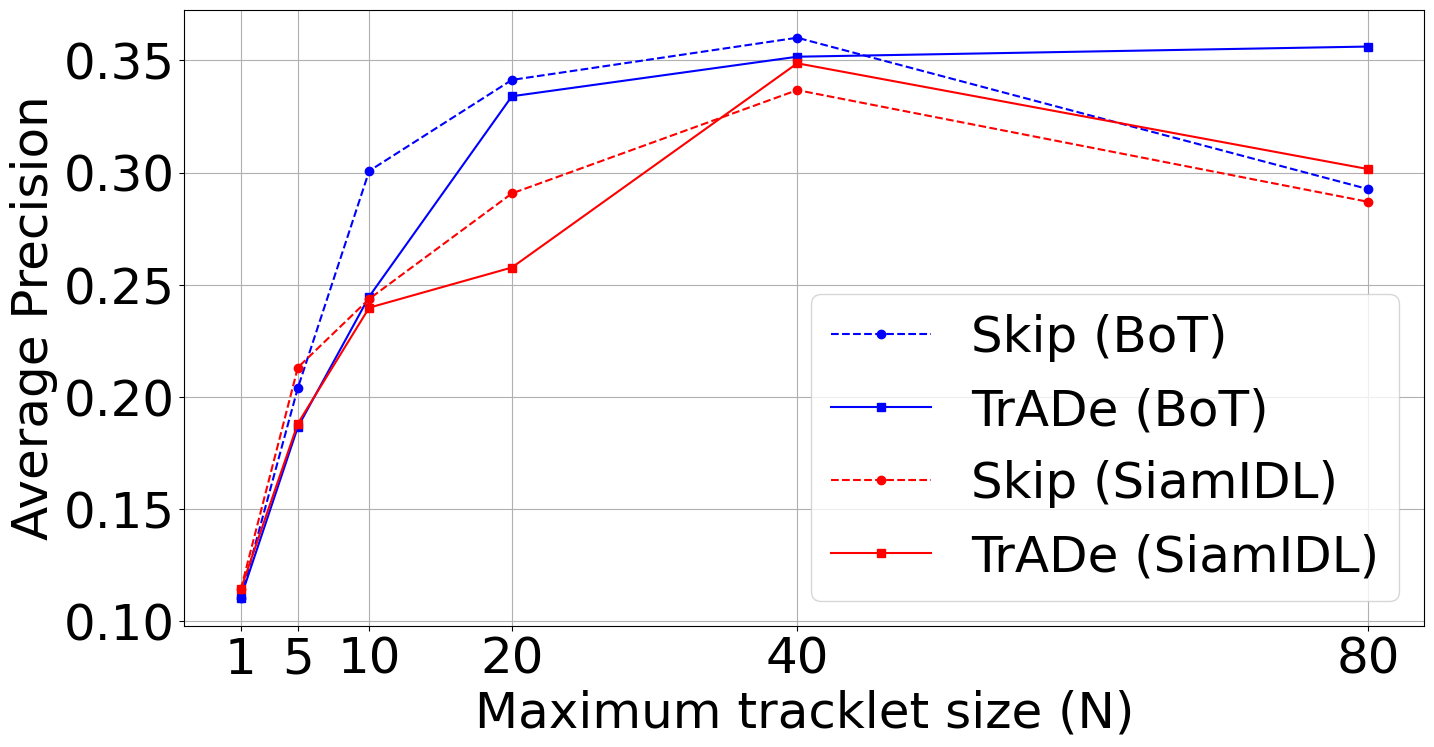

In [65]:

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times New Roman'], 'size':36 })
rc('text', usetex=False)



plt.figure(figsize=(16, 8)) 

axis_Skip = [1, 5, 10, 20, 40, 80]

axis_y1 = list([data_aps_classic_reid_BoT[:,1].astype(float).tolist()[0]]     + all_aps.iloc[:,1:6].iloc[0].to_list())
axis_y2 = list([data_aps_classic_reid_SiamlDL[:,1].astype(float).tolist()[0]] + all_aps.iloc[:,1:6].iloc[1].to_list())

axis_y3 = data_aps_classic_reid_BoT[:,1].astype(float).tolist()
axis_y4 = data_aps_classic_reid_SiamlDL[:,1].astype(float).tolist()

plt.plot(axis_Skip, axis_y3, 'bo--', label='Skip (BoT)')
plt.plot(axis_Skip, axis_y1, 'bs-',  label='TrADe (BoT)')

plt.plot(axis_Skip, axis_y4, 'ro--', label='Skip (SiamIDL)') 
plt.plot(axis_Skip, axis_y2, 'rs-',  label='TrADe (SiamIDL)')


title_aps = 'APs'
plt.legend()
# plt.title(title_aps)
# plt.yticks(np.arange(0, 0.5, step=0.05))
#     plt.xticks(np.arange(0, 90, step=10))
plt.xticks(axis_x1)

plt.grid(True)
plt.xlabel('Maximum tracklet size (N)')
plt.ylabel('Average Precision')



nameFigSave = '{}.png'
nameFigSave = nameFigSave.format(title_aps)
# plt.savefig(os.path.join(path_save_imgs,nameFigSave),dpi=500)   # save the figure to file

plt.show()
    

In [ ]:

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times New Roman'], 'size':36 })
rc('text', usetex=False)



plt.figure(figsize=(16, 8)) 

axis_Skip = [1, 5, 10, 20, 40, 80]

axis_y1 = list([data_aps_classic_reid_BoT[:,1].astype(float).tolist()[0]]     + all_aps.iloc[:,1:6].iloc[0].to_list())
axis_y2 = list([data_aps_classic_reid_SiamlDL[:,1].astype(float).tolist()[0]] + all_aps.iloc[:,1:6].iloc[1].to_list())

axis_y3 = data_aps_classic_reid_BoT[:,1].astype(float).tolist()
axis_y4 = data_aps_classic_reid_SiamlDL[:,1].astype(float).tolist()

# plt.plot(axis_Skip, axis_y3, 'bo--', label='Skip (BoT)')
# plt.plot(axis_Skip, axis_y1, 'bs-',  label='TrADe (BoT)')
plt.plot(axis_Skip, axis_y1, 'bs-',  label='BoT')

# plt.plot(axis_Skip, axis_y4, 'ro--', label='Skip (SiamIDL)') 
# plt.plot(axis_Skip, axis_y2, 'rs-',  label='TrADe (SiamIDL)')
plt.plot(axis_Skip, axis_y2, 'rs-',  label='SiamIDL')


title_aps = 'APs'
plt.legend()
# plt.title(title_aps)
# plt.yticks(np.arange(0, 0.5, step=0.05))
#     plt.xticks(np.arange(0, 90, step=10))
plt.xticks(axis_x1)

plt.grid(True)
plt.xlabel('Maximum tracklet size (N)')
plt.ylabel('Average Precision')



nameFigSave = '{}.png'
nameFigSave = nameFigSave.format(title_aps)
plt.savefig(os.path.join(path_save_imgs,nameFigSave),dpi=500)   # save the figure to file

plt.show()
    

# F-scores and AP

In [ ]:

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times New Roman'], 'size':36 })
rc('text', usetex=False)



plt.figure(figsize=(16, 8)) 

axis_Skip = [1, 5, 10, 20, 40, 80]

axis_y11 = list([data_aps_classic_reid_BoT[:,1].astype(float).tolist()[0]]     + all_aps.iloc[:,1:6].iloc[0].to_list())
axis_y22 = list([data_aps_classic_reid_SiamlDL[:,1].astype(float).tolist()[0]] + all_aps.iloc[:,1:6].iloc[1].to_list())

# axis_y33 = data_aps_classic_reid_BoT[:,1].astype(float).tolist()
# axis_y44 = data_aps_classic_reid_SiamlDL[:,1].astype(float).tolist()

# plt.plot(axis_Skip, axis_y33, 'bo--', label='Skip (BoT)')
plt.plot(axis_Skip, axis_y11, 'bs-',  label='mAP TrADe (BoT)')

# plt.plot(axis_Skip, axis_y44, 'ro--', label='Skip (SiamIDL)') 
plt.plot(axis_Skip, axis_y22, 'rs-',  label='mAP TrADe (SiamIDL)')


title_aps = 'APs'
plt.legend()
# plt.title(title_aps)
# plt.yticks(np.arange(0, 0.5, step=0.05))
#     plt.xticks(np.arange(0, 90, step=10))
plt.xticks(axis_x1)

plt.grid(True)
plt.xlabel('Maximum tracklet size (N)')
plt.ylabel('Average Precision')



nameFigSave = '{}.png'
nameFigSave = nameFigSave.format(title_aps)
plt.savefig(os.path.join(path_save_imgs,nameFigSave),dpi=500)   # save the figure to file

plt.show()
    

In [ ]:

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times New Roman'], 'size':36 })
rc('text', usetex=False)


nameFscore_AP = ["F_05_AP","F_1_AP","F_2_AP"]
nameFscore_AP = ["F_05_AP","F_1_AP","F_2_AP"]

axis_Skip = [1, 5, 10, 20, 40, 80]


for i, fs_i in enumerate([fscore05,fscore10,fscore20]):
    plt.figure(figsize=(16, 8))

    axis_x1 = [1, 5, 10, 20, 40, 80]
    
    axis_y1 = list([data_fscores_classic_reid_BoT[:,i+1].astype(float).tolist()[0]]     + new_all_fscores[fs_i].iloc[0].to_list())
    axis_y2 = list([data_fscores_classic_reid_SiamlDL[:,i+1].astype(float).tolist()[0]] + new_all_fscores[fs_i].iloc[1].to_list())
    
    axis_y3 = data_fscores_classic_reid_BoT[:,i+1].astype(float).tolist()
    axis_y4 = data_fscores_classic_reid_SiamlDL[:,i+1].astype(float).tolist()

    
#     plt.plot(axis_Skip, axis_y3, 'bs--', label='Skip  (BoT)'    ,alpha=1, linewidth=2)
    plt.plot(axis_Skip, axis_y1, 'bs-',  label='$F^*_{1}$ (BoT)'    )

    plt.plot(axis_Skip, axis_y11, 'gs-',  label='mAP (BoT)')
    
#     plt.plot(axis_Skip, axis_y4, 'ro--', label='Skip  (SiamIDL)' ,alpha=0.7, linewidth=2) 
    plt.plot(axis_Skip, axis_y2, 'ro-',  label='$F^*_{1}$ (SiamIDL)' )



    
#     plt.plot(axis_Skip, axis_y3, 'bD-', label=r'Skip(BoT)'    ,alpha=0.3, linewidth=9)
#     plt.plot(axis_Skip, axis_y4, 'rD-', label=r'Skip(SiamlDL)',alpha=0.3, linewidth=9) 

    axis_y11 = list([data_aps_classic_reid_BoT[:,1].astype(float).tolist()[0]]     + all_aps.iloc[:,1:6].iloc[0].to_list())
    axis_y22 = list([data_aps_classic_reid_SiamlDL[:,1].astype(float).tolist()[0]] + all_aps.iloc[:,1:6].iloc[1].to_list())

    # axis_y33 = data_aps_classic_reid_BoT[:,1].astype(float).tolist()
    # axis_y44 = data_aps_classic_reid_SiamlDL[:,1].astype(float).tolist()

    # plt.plot(axis_Skip, axis_y33, 'bo--', label='mAP Skip (BoT)')

    # plt.plot(axis_Skip, axis_y44, 'ro--', label='mAP Skip (SiamIDL)') 
    plt.plot(axis_Skip, axis_y22, 'ys-',  label='mAP (SiamIDL)')

    


#     '-D', alpha=0.8, linewidth=5
    
#     plt.legend()
#     plt.legend( loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1,)
    plt.legend(ncol=2, loc="lower right")
#     plt.title(fs_i)
#     plt.yticks(np.arange(0.20, 0.71, step=0.1))
#     plt.xticks(np.arange(0, 90, step=10))
    plt.xticks(axis_x1)
    
    plt.grid(True)
    
    nameFigSave = '{}.png'
    nameFigSave = nameFigSave.format(nameFscore_AP[i])
    plt.xlabel('Maximum tracklet size (N)')
#     plt.ylabel('F-score ')
#     plt.ylabel(title_fscores[i])
    
    plt.tight_layout() 
#     plt.savefig(os.path.join(path_save_imgs,nameFigSave),bbox_inches='tight')   # save the figure to file
    plt.savefig(os.path.join(path_save_imgs,nameFigSave))   # save the figure to file
    plt.show()
    

# new Fscores

In [ ]:
# ‘b’	blue
# ‘g’	green
# ‘r’	red
# ‘c’	cyan
# ‘m’	magenta
# ‘y’	yellow
# ‘k’	black
# ‘w’	white


In [ ]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times New Roman'], 'size':36 })
rc('text', usetex=False)


title_fscores = ["$F^*_{0.5}$","$F^*_{1.0}$","$F^*_{2.0}$"]

plt.figure(figsize=(16, 12))


LineFscores = [['gs--','gs-','ys--','ys-'],['bs--','bs-','cs--','cs-'],['rs--','rs-','ms--','ms-']]

# propFscores = [["$F^*_{0.5}$",'green'],["$F^*_{1.0}$", 'blue'],["$F^*_{2.0}$",'red']]
propFscores = [["$F^*_{0.5}$",'g','y'],["$F^*_{1.0}$", 'b','c'],["$F^*_{2.0}$",'r','m']]

axis_Skip  = [1, 5, 10, 20, 40, 80]
axis_TrADe = [5, 10, 20, 40, 80]

for i, fs_i in enumerate([fscore05,fscore10,fscore20]):

    
    axis_y1 = list([data_fscores_classic_reid_BoT[:,i+1].astype(float).tolist()[0]]     + new_all_fscores[fs_i].iloc[0].to_list())
    axis_y2 = list([data_fscores_classic_reid_SiamlDL[:,i+1].astype(float).tolist()[0]] + new_all_fscores[fs_i].iloc[1].to_list())
    
    axis_y3 = data_fscores_classic_reid_BoT[:,i+1].astype(float).tolist()
    axis_y4 = data_fscores_classic_reid_SiamlDL[:,i+1].astype(float).tolist()

    plt.plot(axis_Skip, axis_y3, LineFscores[i][0], label='Skip  (BoT)'    ,alpha=1, linewidth=2)
    plt.plot(axis_Skip, axis_y1, LineFscores[i][1],  label='TrADe (BoT)'    ,alpha=1, linewidth=2)
    plt.plot(axis_Skip, axis_y4, LineFscores[i][2], label='Skip  (SiamIDL)' ,alpha=0.7, linewidth=2) 
    plt.plot(axis_Skip, axis_y2, LineFscores[i][3],  label='TrADe (SiamIDL)' ,alpha=0.7, linewidth=2)


# plt.legend()
#     plt.title(fs_i)
plt.yticks(np.arange(0.20, 0.71, step=0.1))
#     plt.xticks(np.arange(0, 90, step=10))
plt.xticks(axis_x1)

plt.grid(True)

nameFigSave = '{}.png'
nameFigSave = nameFigSave.format(fs_i)
plt.xlabel('Maximum tracklet size (N)')
#     plt.ylabel('F-score ')
# plt.ylabel(title_fscores[i])
plt.ylabel("$F^*_{\gamma}$")




namesFs = list()
for _name,_color,_color2 in propFscores:
#     namesFs.append(mpatches.Patch(lw=1,color=_color, label=_name,fill=True))
    namesFs.append(Line2D([0], [0], color=_color, lw=2, label=_name, linestyle='-'))
    namesFs.append(Line2D([0], [0], color=_color2, lw=2, label='',    linestyle='-'))


# TradeColor = mpatches.Patch(color='black', label='TrADe (BoT)')
# SiamIDL    = mpatches.Patch(color='black', label='Skip  (SiamIDL)')

TradeColor = Line2D([0], [0], color='black', lw=2, label='TrADe (BoT)',     linestyle='-')
SiamIDL    = Line2D([0], [0], color='black', lw=2, label='Skip  (SiamIDL)', linestyle='--')



first_legend = plt.legend(handles=[TradeColor,SiamIDL], loc='upper center', bbox_to_anchor=(0.5, 1.20), ncol=2,) #loc='upper left'
first_legend2 = plt.legend(handles=namesFs, loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1, ) #loc='upper right'
# first_legend2 = plt.legend(handles=namesFs, loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=3, ) #loc='upper right'

plt.gca().add_artist(first_legend)
plt.gca().add_artist(first_legend2)

# plt.legend()

plt.savefig(os.path.join(path_save_imgs,'F_gamma_Score'),bbox_inches='tight')   # save the figure to file
plt.show()





In [ ]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

from matplotlib.legend_handler import HandlerBase

class AnyObjectHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        lw = 4
        l1 = plt.Line2D([x0,y0+width], [0.1*height,0.1*height], linestyle=orig_handle[3], color=orig_handle[0],lw=lw)
        l2 = plt.Line2D([x0,y0+width], [0.4*height,0.4*height], linestyle=orig_handle[1], color=orig_handle[0],lw=lw)
        l3 = plt.Line2D([x0,y0+width], [0.7*height,0.7*height], linestyle=orig_handle[3] ,color=orig_handle[2],lw=lw)
        l4 = plt.Line2D([x0,y0+width], [1.0*height,1.0*height], linestyle=orig_handle[1], color=orig_handle[2],lw=lw)

        return [ l1,l2,l3,l4, ]

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times New Roman'], 'size':36 })
rc('text', usetex=False)


title_fscores = ["$F^*_{0.5}$","$F^*_{1.0}$","$F^*_{2.0}$"]

plt.figure(figsize=(16, 12))


LineFscores = [['gs--','gs-','ys--','ys-'],['bs--','bs-','cs--','cs-'],['rs--','rs-','ms--','ms-']]

# propFscores = [["$F^*_{0.5}$",'green'],["$F^*_{1.0}$", 'blue'],["$F^*_{2.0}$",'red']]
propFscores = [["$F^*_{0.5}$",'g','y'],["$F^*_{1.0}$", 'b','c'],["$F^*_{2.0}$",'r','m']]


axis_Skip  = [1, 5, 10, 20, 40, 80]
axis_TrADe = [5, 10, 20, 40, 80]


for i, fs_i in enumerate([fscore05,fscore10,fscore20]):

    
    axis_y1 = list([data_fscores_classic_reid_BoT[:,i+1].astype(float).tolist()[0]]     + new_all_fscores[fs_i].iloc[0].to_list())
    axis_y2 = list([data_fscores_classic_reid_SiamlDL[:,i+1].astype(float).tolist()[0]] + new_all_fscores[fs_i].iloc[1].to_list())
    
    axis_y3 = data_fscores_classic_reid_BoT[:,i+1].astype(float).tolist()
    axis_y4 = data_fscores_classic_reid_SiamlDL[:,i+1].astype(float).tolist()

    plt.plot(axis_Skip, axis_y3, LineFscores[i][0], label='Skip  (BoT)'    ,alpha=1, linewidth=2)
    plt.plot(axis_Skip, axis_y1, LineFscores[i][1],  label='TrADe (BoT)'    ,alpha=1, linewidth=2)
    plt.plot(axis_Skip, axis_y4, LineFscores[i][2], label='Skip  (SiamIDL)' ,alpha=0.7, linewidth=2) 
    plt.plot(axis_Skip, axis_y2, LineFscores[i][3],  label='TrADe (SiamIDL)' ,alpha=0.7, linewidth=2)
    

# plt.legend()
#     plt.title(fs_i)
plt.yticks(np.arange(0.20, 0.71, step=0.1))
#     plt.xticks(np.arange(0, 90, step=10))
plt.xticks(axis_x1)

plt.grid(True)

nameFigSave = '{}.png'
nameFigSave = nameFigSave.format(fs_i)
plt.xlabel('Maximum tracklet size (N)')
#     plt.ylabel('F-score ')
# plt.ylabel(title_fscores[i])
plt.ylabel("$F^*_{\gamma}$")




namesFs = list()
namesFs2 = list()
namesFs3 = list()
for _name,_color,_color2 in propFscores:
#     namesFs.append(mpatches.Patch(lw=1,color=_color, label=_name,fill=True))
    namesFs.append(Line2D([0], [0], color=_color, lw=2, label=_name, linestyle='-'))
    namesFs.append(Line2D([0], [0], color=_color2, lw=2, label='',    linestyle='-'))
    
    namesFs2.append((_color,'-',_color2,'--'))
    namesFs3.append(_name)
    
    
# TradeColor = mpatches.Patch(color='black', label='TrADe (BoT)')
# SiamIDL    = mpatches.Patch(color='black', label='Skip  (SiamIDL)')

TradeColor = Line2D([0], [0], color='black', lw=4, label='TrADe (BoT)',     linestyle='-')
SiamIDL    = Line2D([0], [0], color='black', lw=4, label='Skip  (SiamIDL)', linestyle='--')



first_legend = plt.legend(handles=[TradeColor,SiamIDL], loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=2,) #loc='upper left'
# first_legend2 = plt.legend(handles=namesFs, loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1, ) #loc='upper right'
first_legend2 = plt.legend(namesFs2, namesFs3, handler_map={tuple: AnyObjectHandler()}, loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1,)

plt.gca().add_artist(first_legend)
plt.gca().add_artist(first_legend2)

# plt.legend()

plt.savefig(os.path.join(path_save_imgs,'F_gamma_Score'),bbox_inches='tight')   # save the figure to file
plt.show()





# Testing Plot Average Precision

In [ ]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times New Roman'], 'size':12 })
rc('text', usetex=False)

In [ ]:
FR_eta_20_tau_1000_trade_BoT, TVR_eta_20_tau_1000_trade_BoT = all_FR_TVR[0][0][0], all_FR_TVR[0][0][1]

In [ ]:
import random
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

recall    = FR_eta_20_tau_1000_trade_BoT[::-1]
precision = TVR_eta_20_tau_1000_trade_BoT[::-1]


area = 0
# area = auc(precision,recall)
[area, mpre, mrec, ii] = CalculateAveragePrecision(recall,precision)
# [area, _, _, _] = CalculateAveragePrecision(recall,precision)
print("Area Under Curve: %0.2f" % area)




plt.figure(figsize=(8,8))
plt.plot(recall, precision, 'ro', label='x1')
plt.plot(recall, precision, label='x2', drawstyle='steps')
plt.step(mrec,   mpre, '--', label='x3')
plt.plot(mrec,   mpre, 'bo', label='x4')

plt.fill_between(mrec,   mpre, step="pre", alpha=0.4)


# plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

for i, _ in enumerate(recall):
    plt.annotate(i, (recall[i], precision[i]))

plt.xlabel('recall')
plt.ylabel('precision')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.title('ROC_curve example: AUC=%0.2f' % area)
plt.legend(loc="lower left")
plt.show()

# Test FPR vs TPR

In [ ]:
def FPR(dictTypes):
    if isinstance(dictTypes,dict) is False:
        raise Exception('dictTypes is not a dictionary')
    # FPR =  ( TMC + FC )  / ( TMC + FC +  TS )
    tmc = dictTypes.get('TrueMissedCall') if dictTypes.get('TrueMissedCall') else 0
    fc  = dictTypes.get('FalseCall')      if dictTypes.get('FalseCall')      else 0
    ts  = dictTypes.get('TrueSilence')    if dictTypes.get('TrueSilence')    else 0
    
    if (tmc + fc + ts)==0:
        return 0
#     return  (tmc + fc) / (tmc + fc + ts)
#     print("tmc + fc + ts :", tmc, fc, ts, "->>: ", tmc + fc + ts)
#     print("result FPR: ", (fc) / (tmc + fc + ts))
    return  (fc) / (fc + tmc + ts)

def TPR(dictTypes):
    if isinstance(dictTypes,dict) is False:
        raise Exception('dictTypes is not a dictionary')
    # TPR =  ( TC )  / ( TC + TMC +  FS )
    tmc = dictTypes.get('TrueMissedCall') if dictTypes.get('TrueMissedCall') else 0
    tc  = dictTypes.get('TrueCall')       if dictTypes.get('TrueCall')       else 0
    fs  = dictTypes.get('FalseSilence')   if dictTypes.get('FalseSilence')   else 0
    if (tmc + tc + fs)==0:
        return 0
#     print("tc + tmc + fs :", tc, tmc, fs, "->>: ", tmc + tc + fs)
#     print("result TPR: ", (tc) / (tc + tmc + fs))
    return  (tc) / (tc + tmc + fs)


In [ ]:
def ROC_curve(df, thrs_list, eta, tau):
    result_FPR = list() 
    result_TPR = list() 
    for thr in thrs_list:
        tmp_df     = None
        tmp_dict   = None
        tmp_df   = request_data(df, thr, eta, tau)
#         print("tmp_df: ",tmp_df)

        tmp_dict = tmp_df['type'].value_counts().to_dict()

#         print("tmp_dict: ",tmp_dict)
#         print("thr: ", thr)
#         print("FPR: ", FPR(tmp_dict))
#         print("TPR: ", TPR(tmp_dict))
        result_FPR.append( FPR(tmp_dict) )
        result_TPR.append( TPR(tmp_dict) )   
    return result_FPR, result_TPR

In [ ]:
import random
import pylab as pl
from sklearn import svm, datasets
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

FPR, TPR = ROC_curve(all_dfs_resultGUI[0][0], thrs_list , eta=20, tau=1000 )

area = 0
# area = auc(FPR, TPR)
# area = auc(precision,recall)
print("Area Under Curve: %0.2f" % area)

pl.clf()
pl.plot(FPR, TPR, 'ro', label='curve')
pl.plot(FPR, TPR, label='curve')
# pl.step(recall, precision, where='post', label='step')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

pl.xlabel('FPR')
pl.ylabel('TPR')
# pl.ylim([0.0, 1.05])
# pl.xlim([0.0, 1.0])
pl.title('ROC_curve example: AUC=%0.2f' % area)
pl.legend(loc="lower left")
pl.show()